In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

In [16]:
url = "Big Data/quantity_sums.csv"

data = pd.read_csv(url)

In [17]:
import pandas as pd

# Find unique CUSTOMER_NUMBER values and sort them
unique_customers = sorted(data['CUSTOMER_NUMBER'].unique())

# Create a dictionary to store data for each customer
customer_data = {}

# Create a dictionary to store xts data for each customer
xts_data = {}

# Iterate over unique customer numbers
for customer_number in unique_customers:
    # Subset the data for the current customer number
    customer_subset = data[data['CUSTOMER_NUMBER'] == customer_number].drop(columns=['CUSTOMER_NUMBER'])
    # Store the subset data in the dictionary with customer number as key
    customer_data[customer_number] = customer_subset

    # Print unique TERMINAL_PRODUCT_NUMBER for the current customer
    unique_terminal_product_numbers = sorted(customer_subset['TERMINAL_PRODUCT_NUMBER'].unique())
    print(f"Customer {customer_number}: {unique_terminal_product_numbers}")

    # Create variables dynamically for each product number for the current customer
    for product_number in unique_terminal_product_numbers:
        # Construct variable name
        variable_name = f"data_customer_{customer_number}_product_number_{product_number}"
        # Filter data for the current product number
        filtered_data = customer_subset[customer_subset['TERMINAL_PRODUCT_NUMBER'] == product_number].drop(columns=['TERMINAL_PRODUCT_NUMBER'])
        # Assign the filtered data to the dynamically created variable
        globals()[variable_name] = filtered_data

        # Convert FOLIO_NUMBER to datetime format if the column exists
        folio_number_column = f"FOLIO_NUMBER"
        if folio_number_column in filtered_data.columns:
            filtered_data[folio_number_column] = pd.to_datetime(filtered_data[folio_number_column], format='%Y%m%d')

        # Create xts dynamically for each product number
        xts_variable_name = f"xts_data_customer_{customer_number}_product_number_{product_number}"
        xts_data[xts_variable_name] = pd.Series(filtered_data['ORDERED_QUANTITY'].values, index=filtered_data[folio_number_column])

Customer 1: [4, 7]
Customer 2: [4, 7]
Customer 3: [4, 7, 8, 9, 10, 11]
Customer 5: [4, 7, 10, 12, 13]
Customer 6: [4, 7]
Customer 7: [4, 7]
Customer 8: [4, 7, 10, 11]
Customer 9: [4, 7]
Customer 12: [4, 7]
Customer 13: [4, 7]
Customer 14: [4, 7]
Customer 15: [4, 7]
Customer 16: [4, 7]
Customer 17: [4, 7]
Customer 18: [4, 7]
Customer 19: [4, 7]
Customer 20: [4, 7]


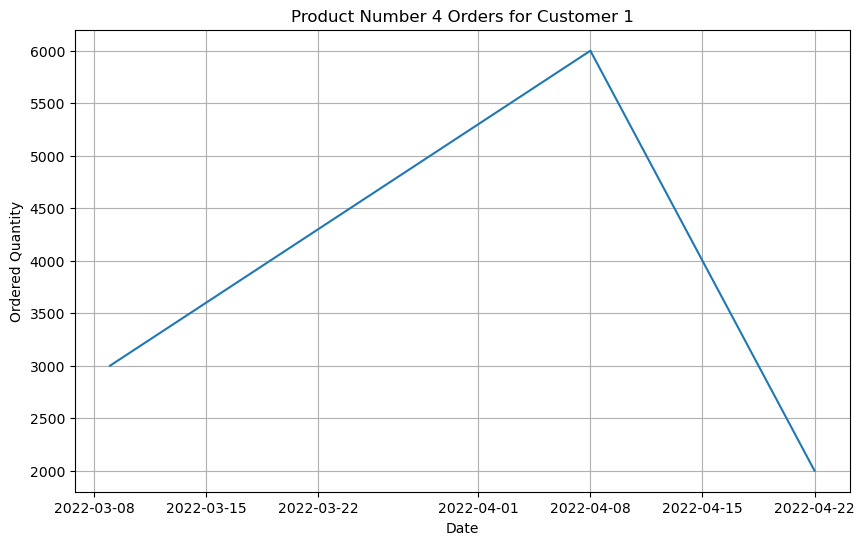

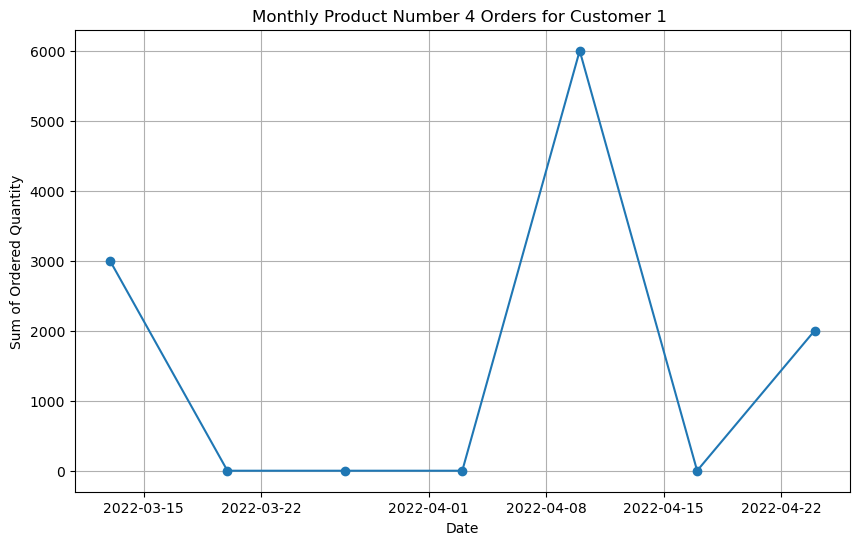

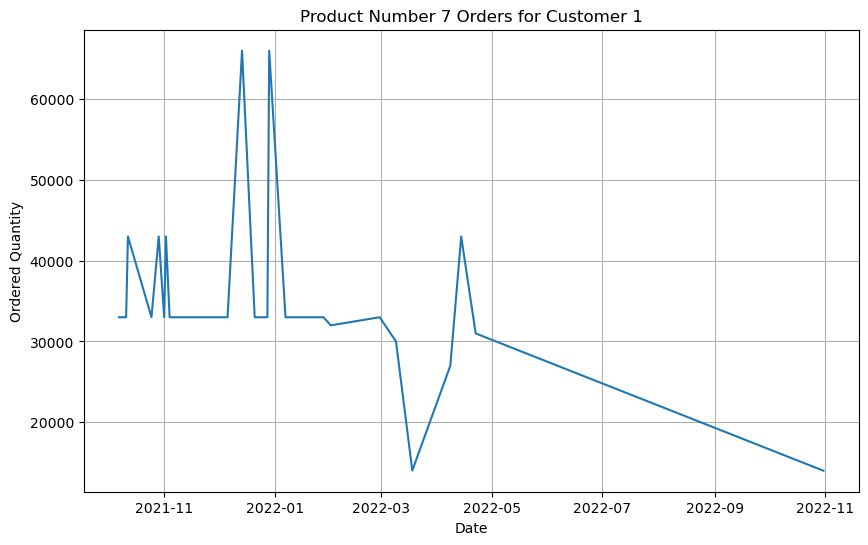

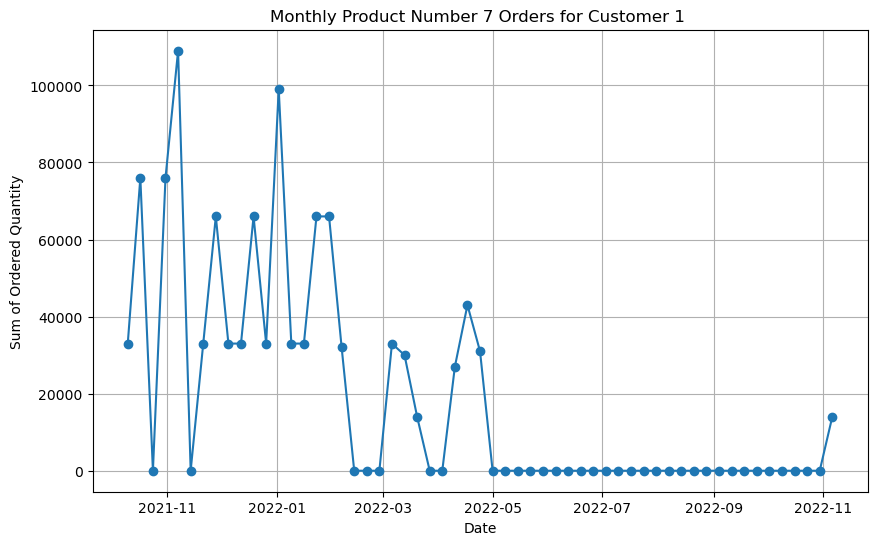

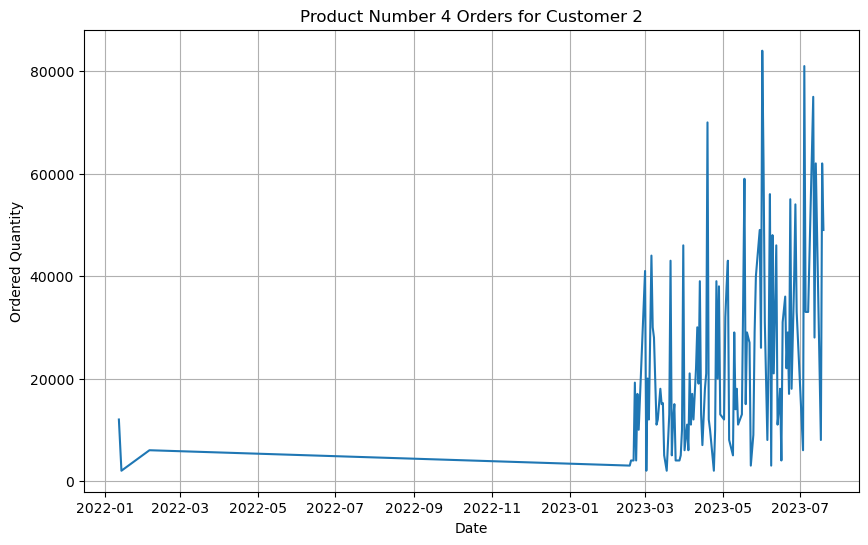

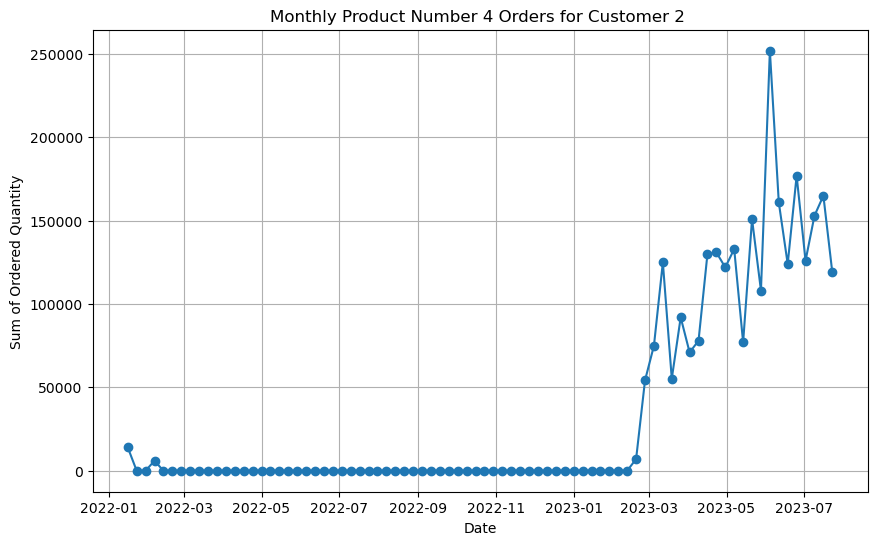

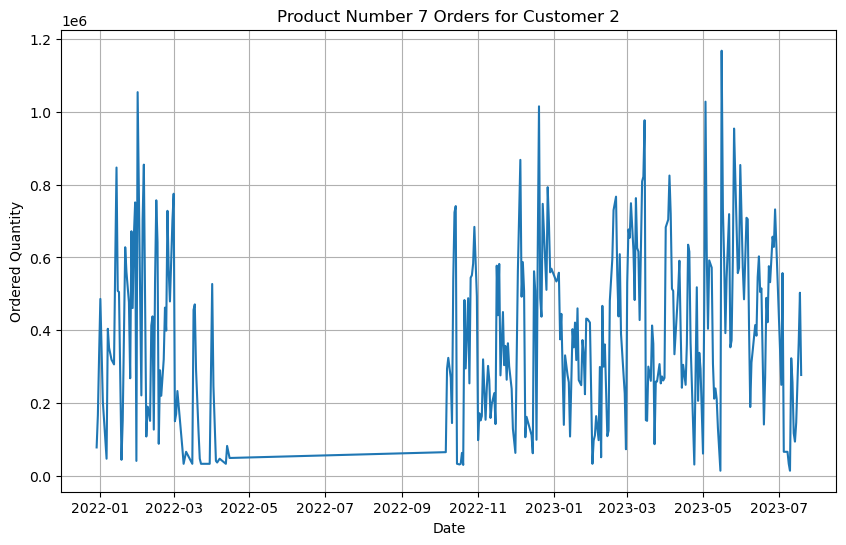

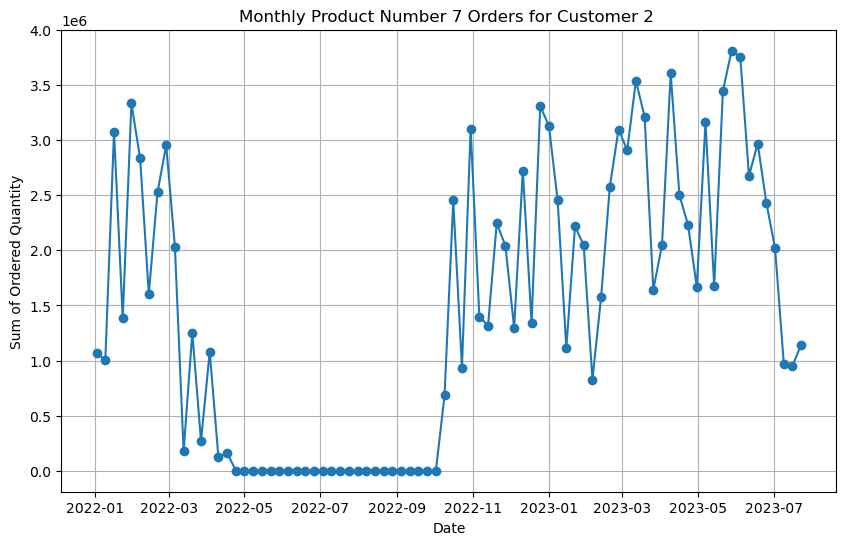

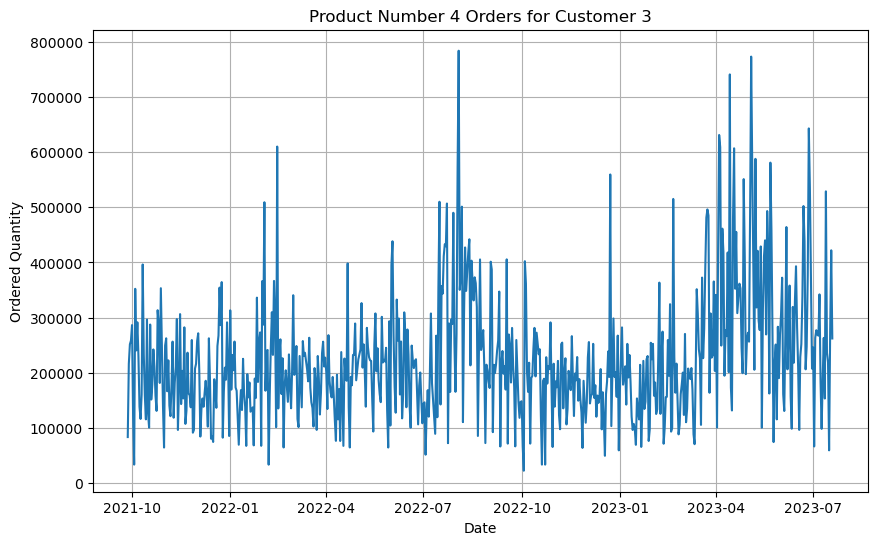

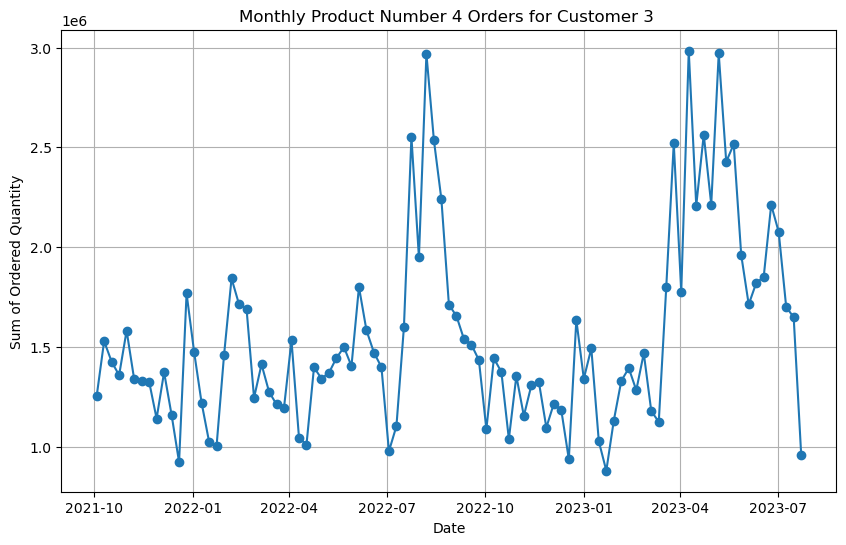

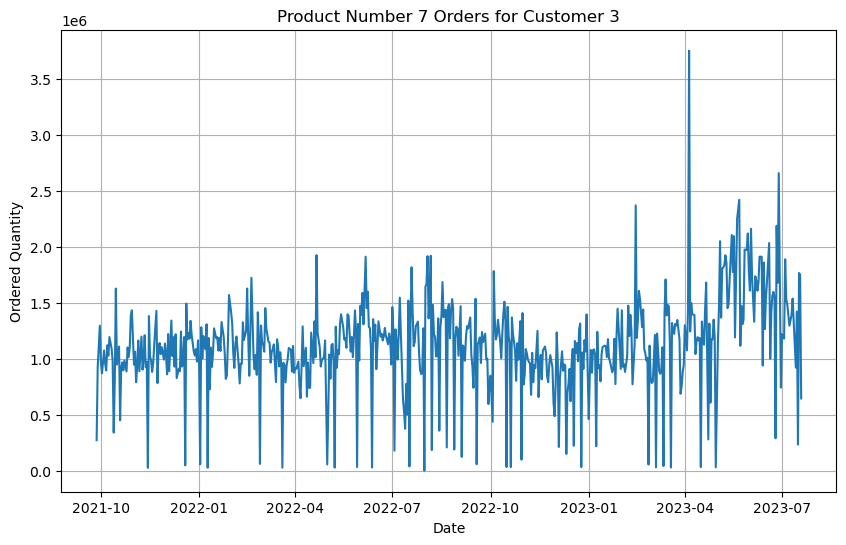

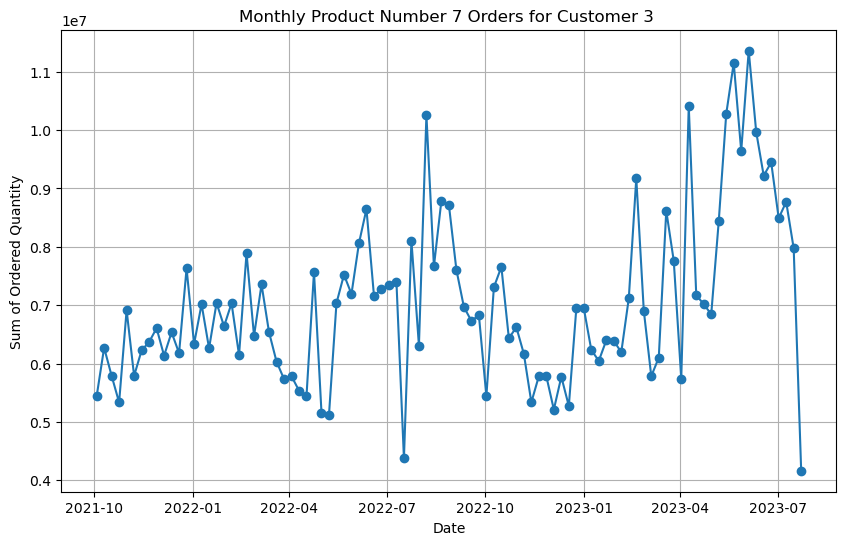

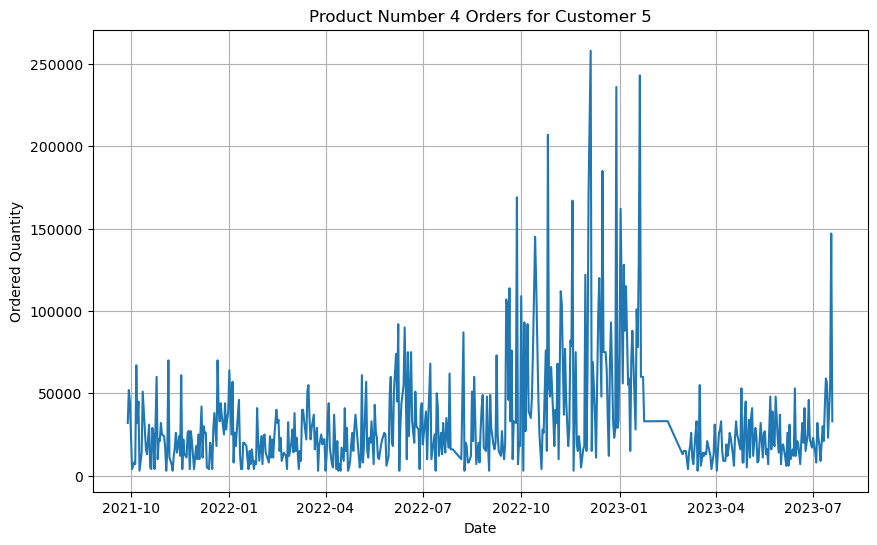

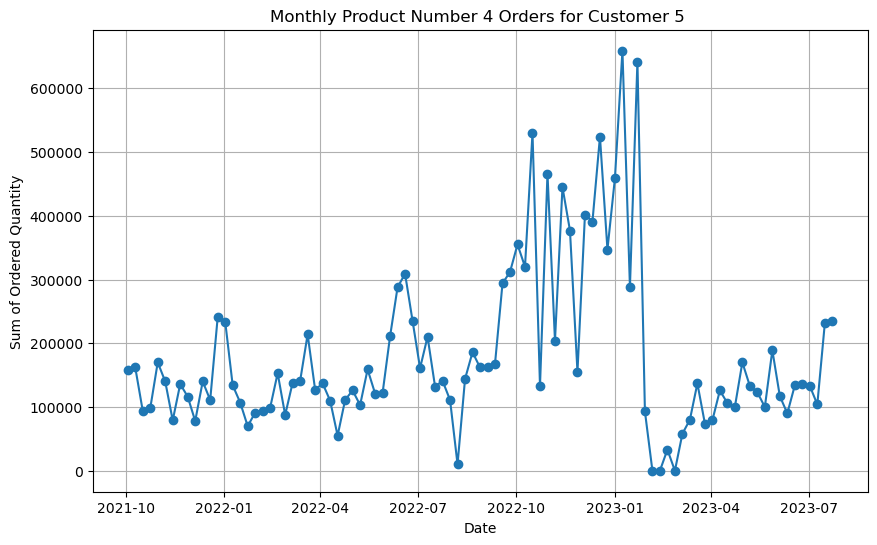

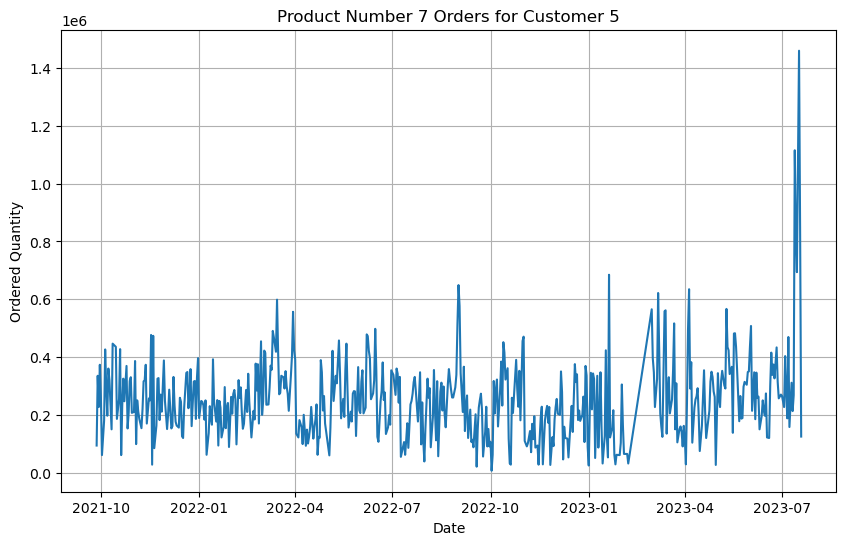

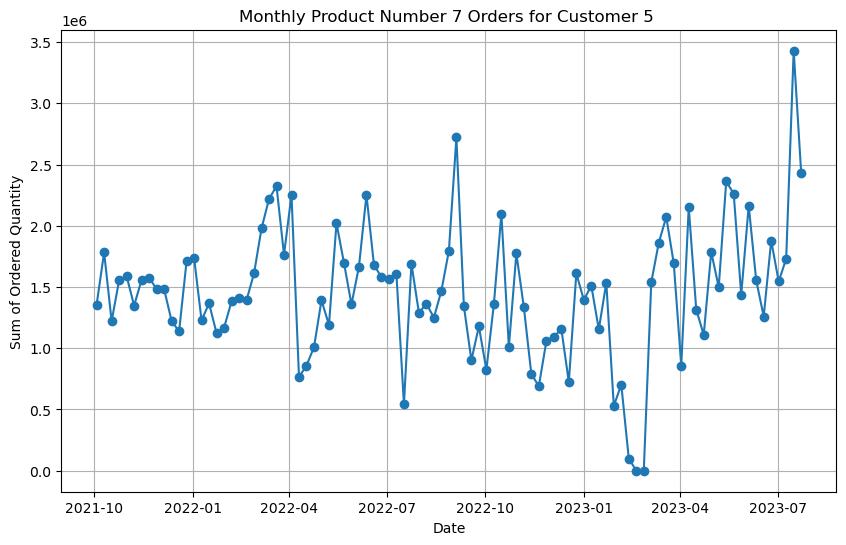

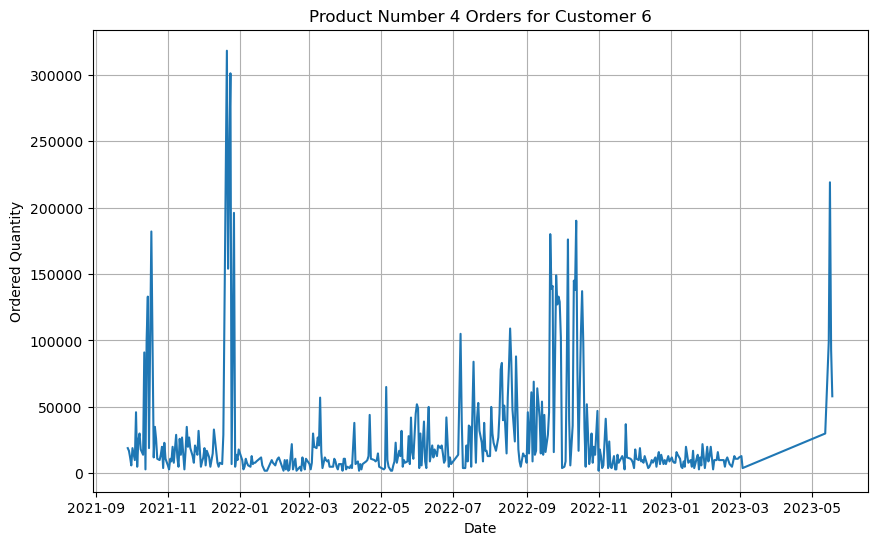

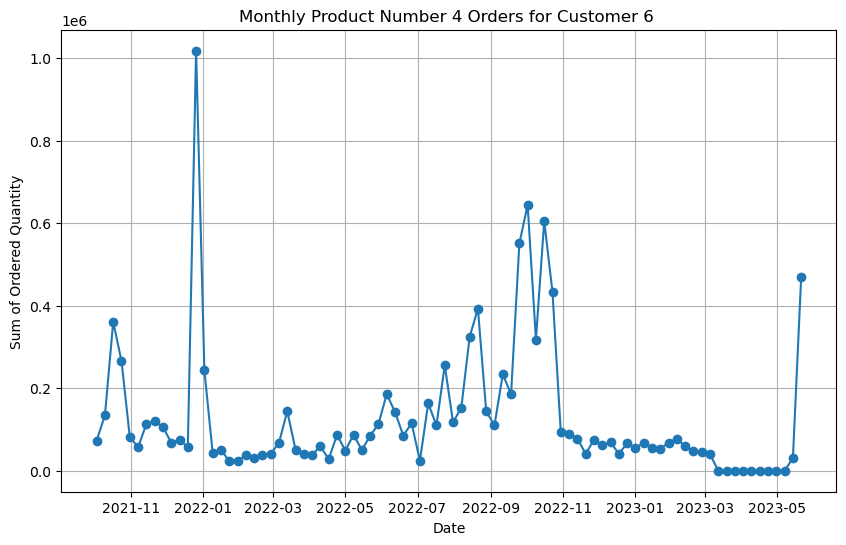

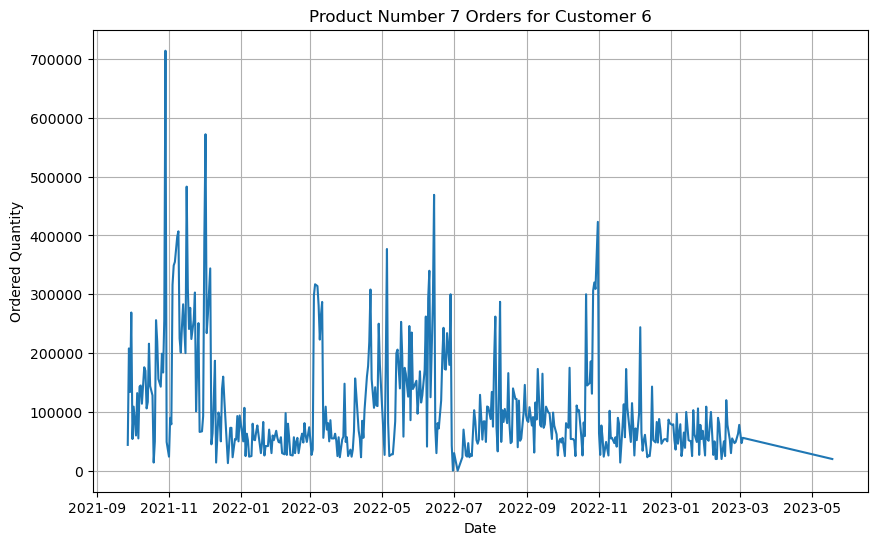

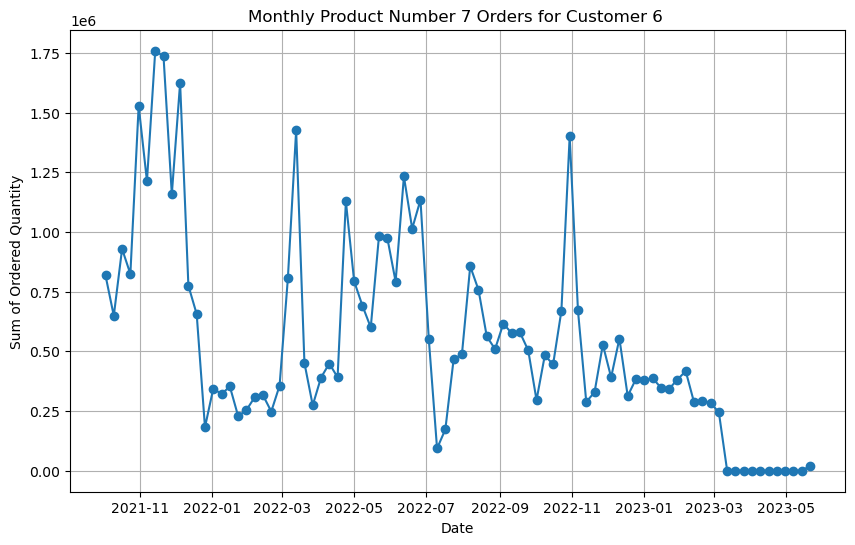

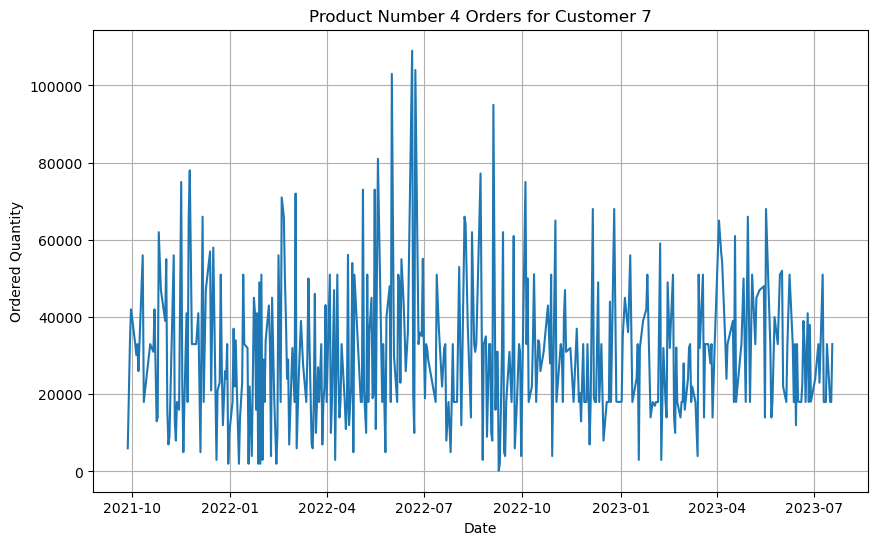

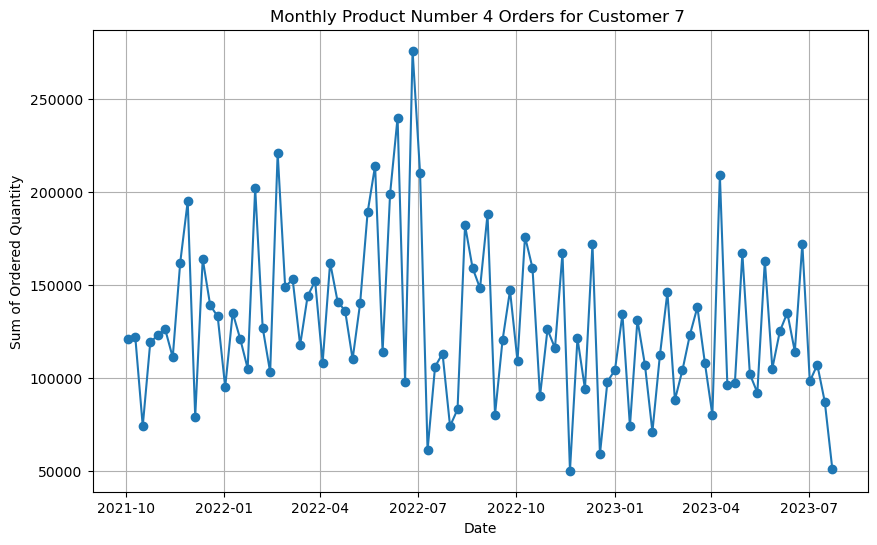

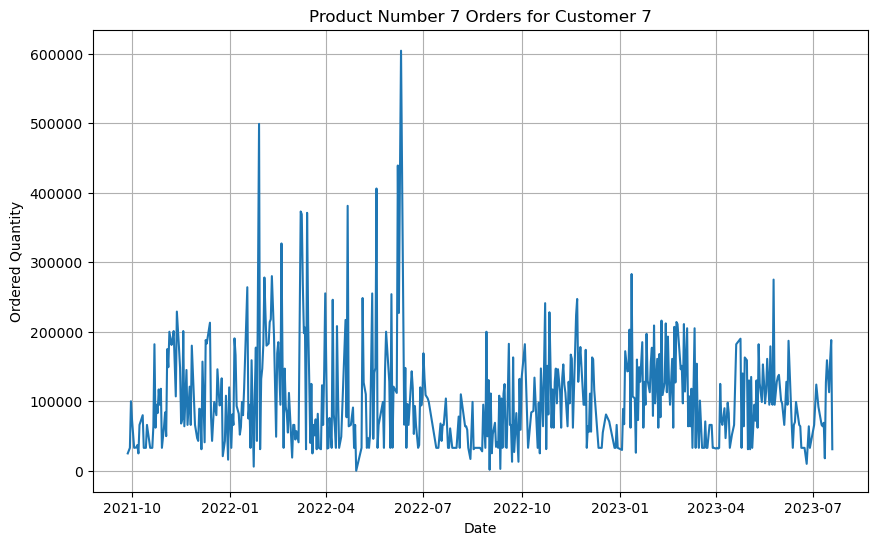

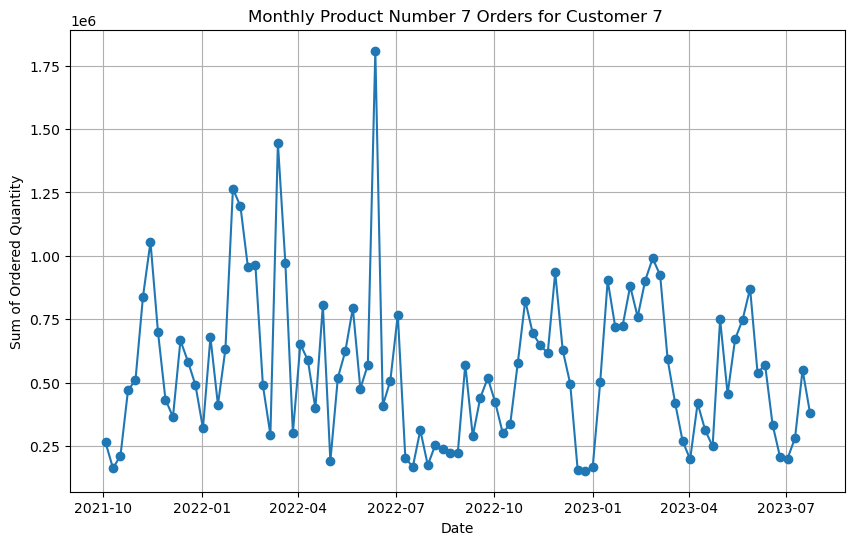

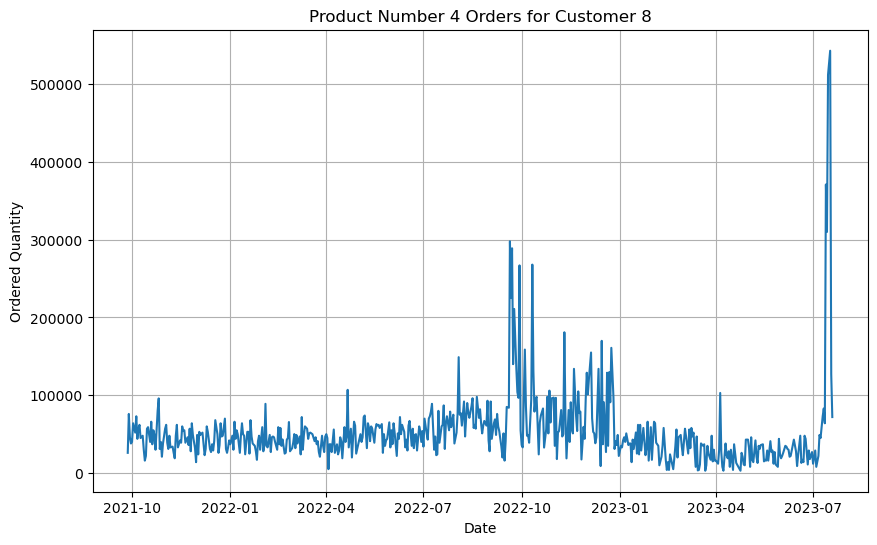

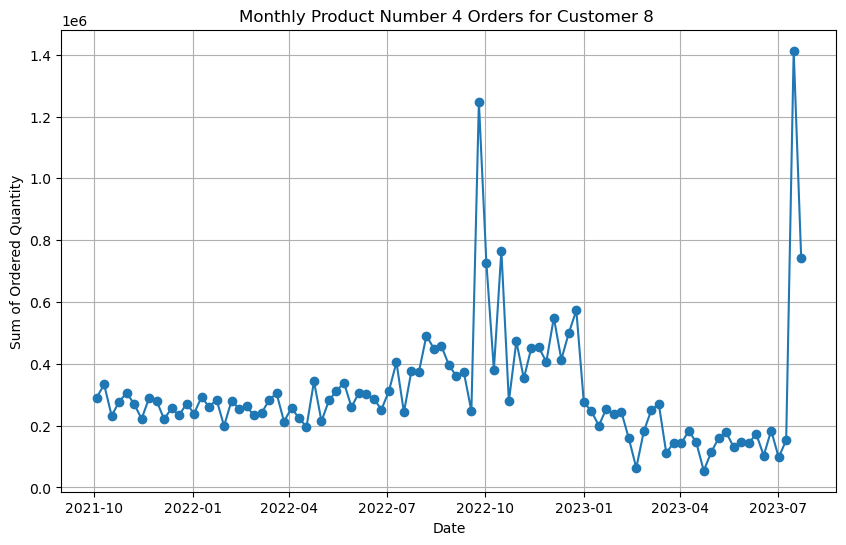

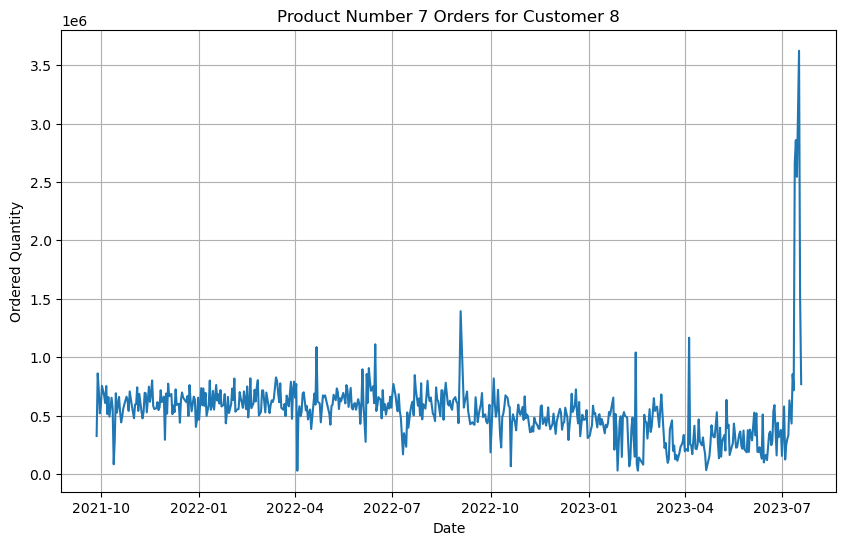

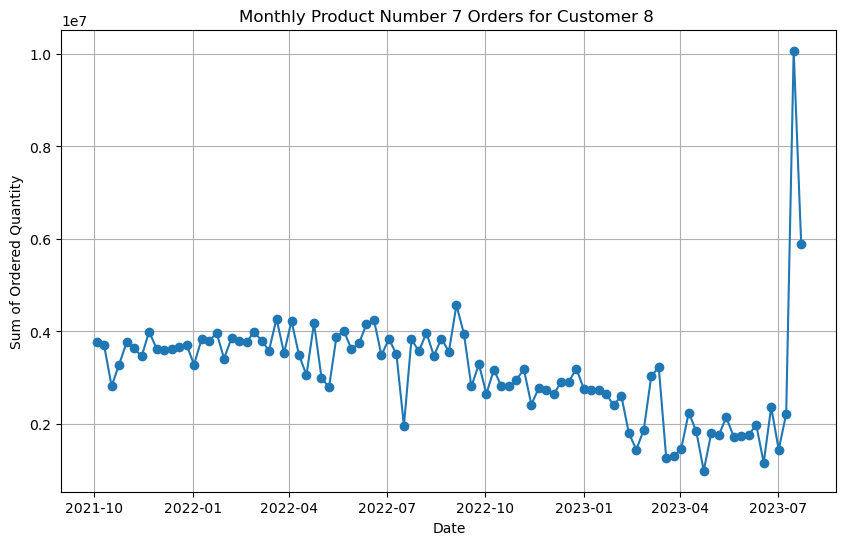

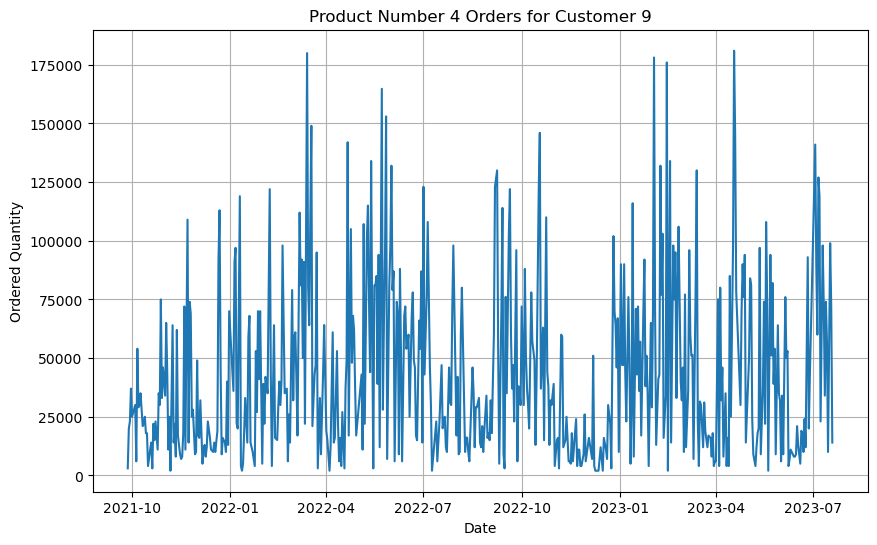

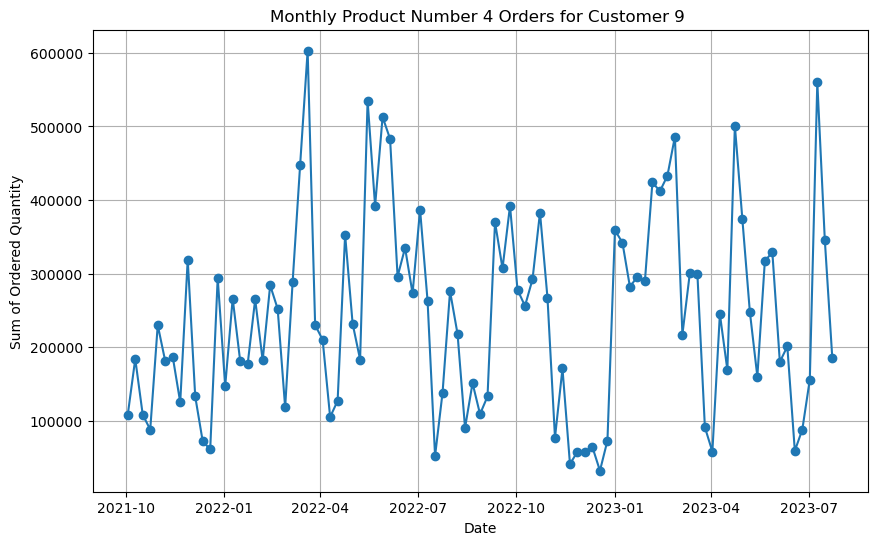

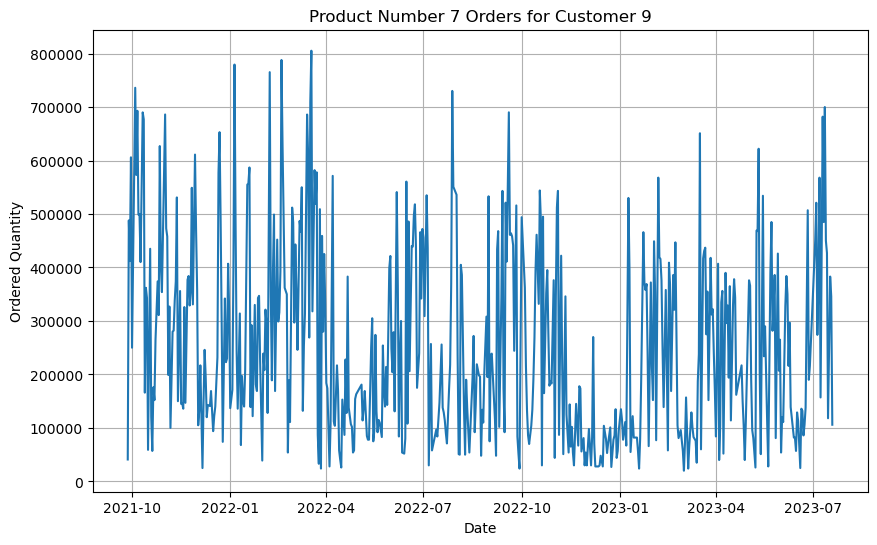

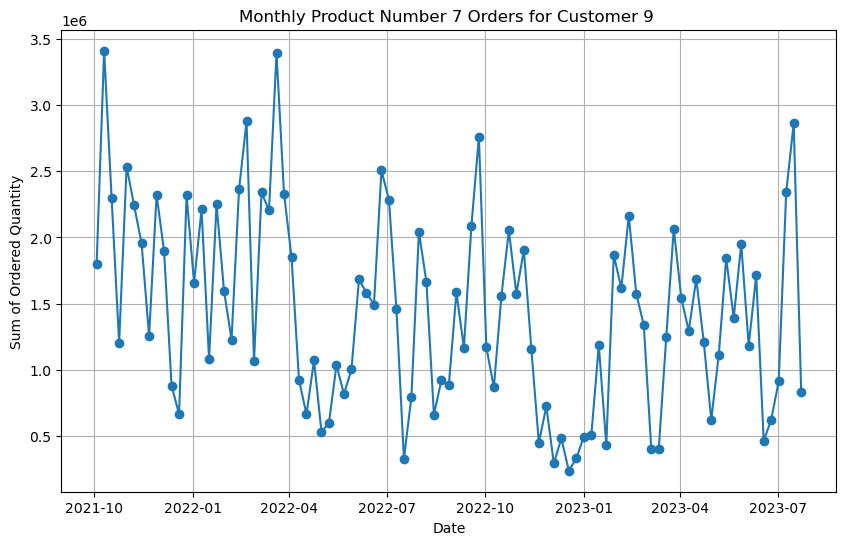

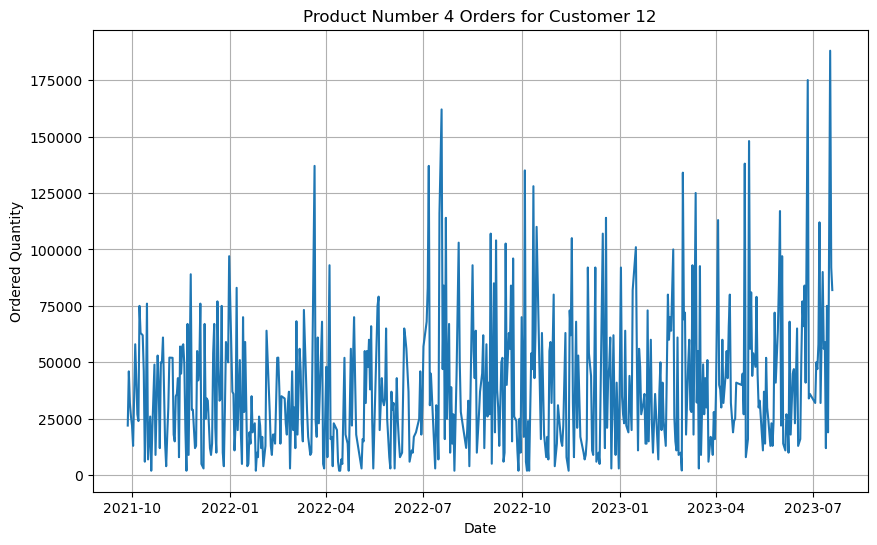

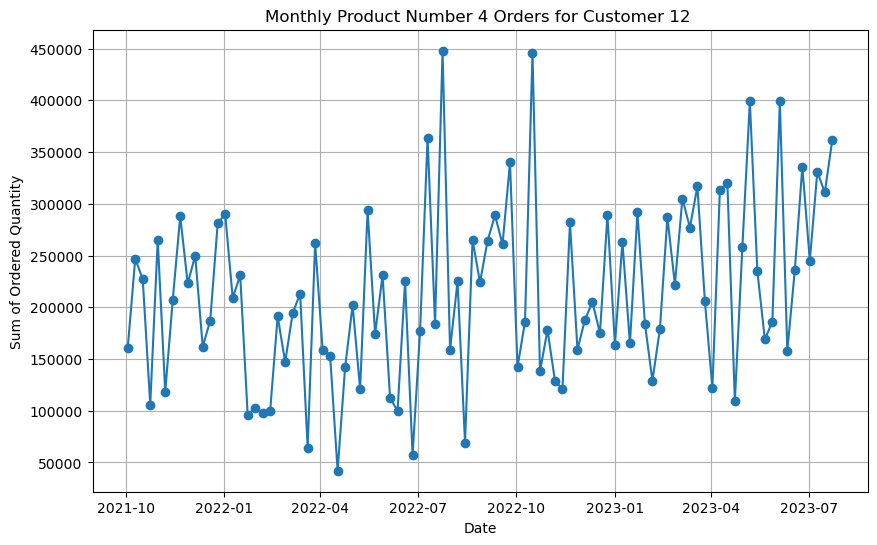

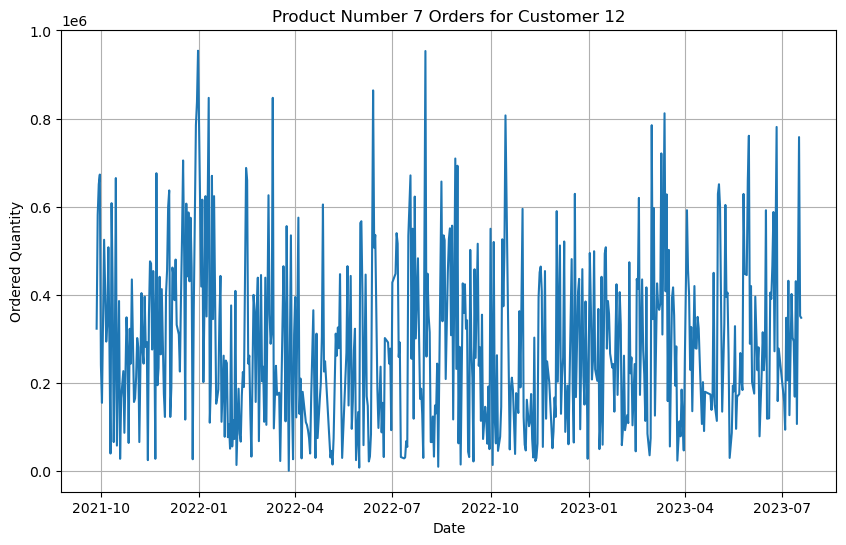

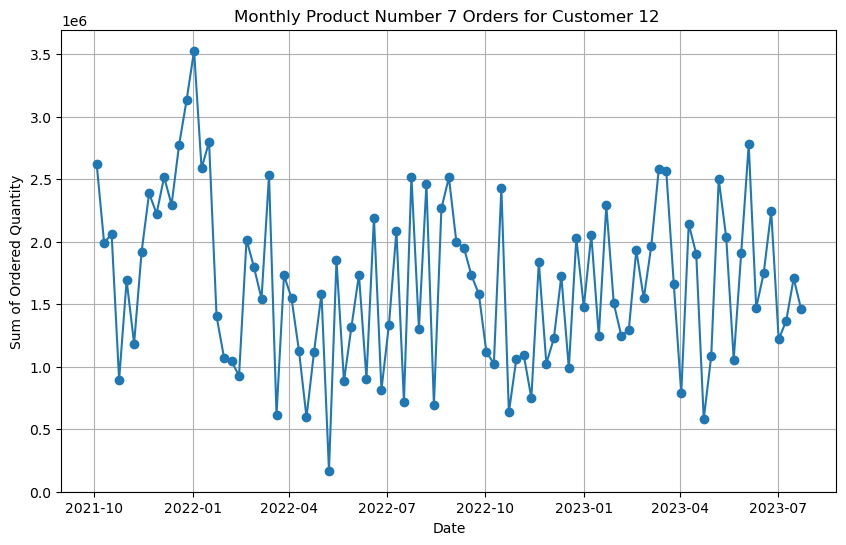

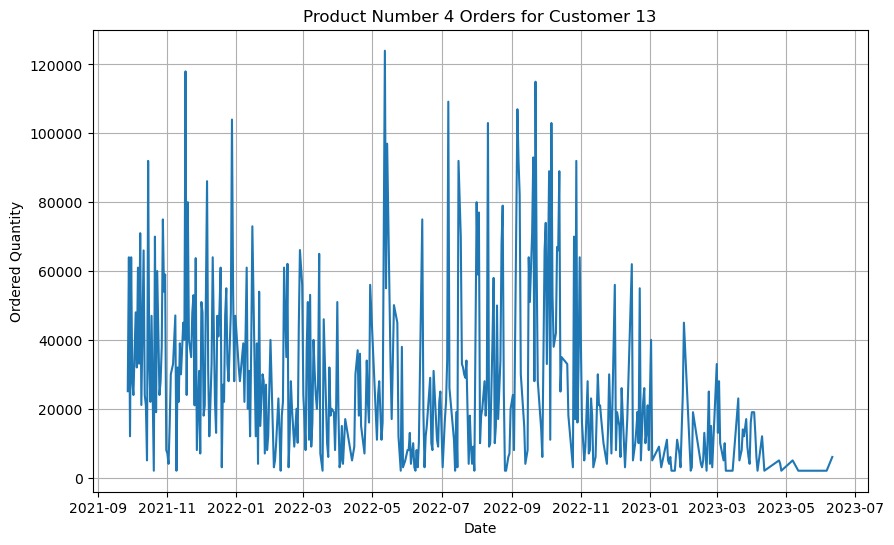

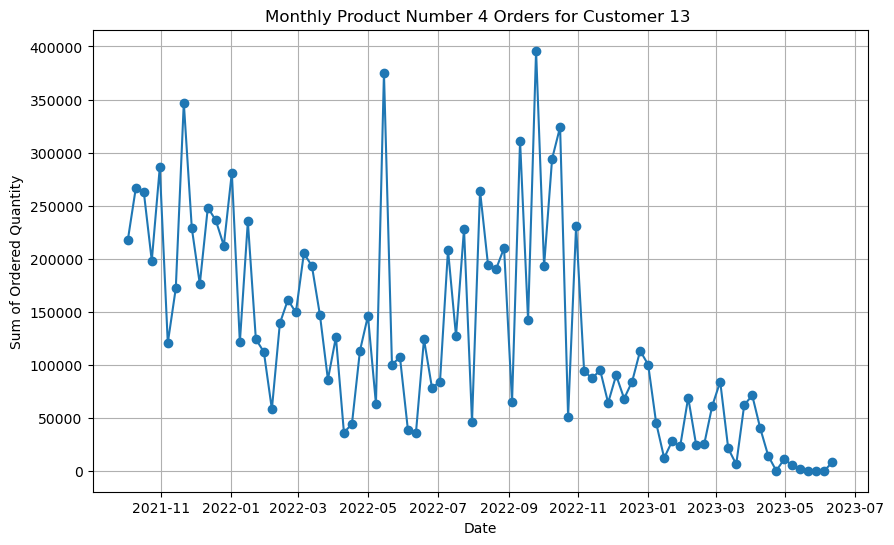

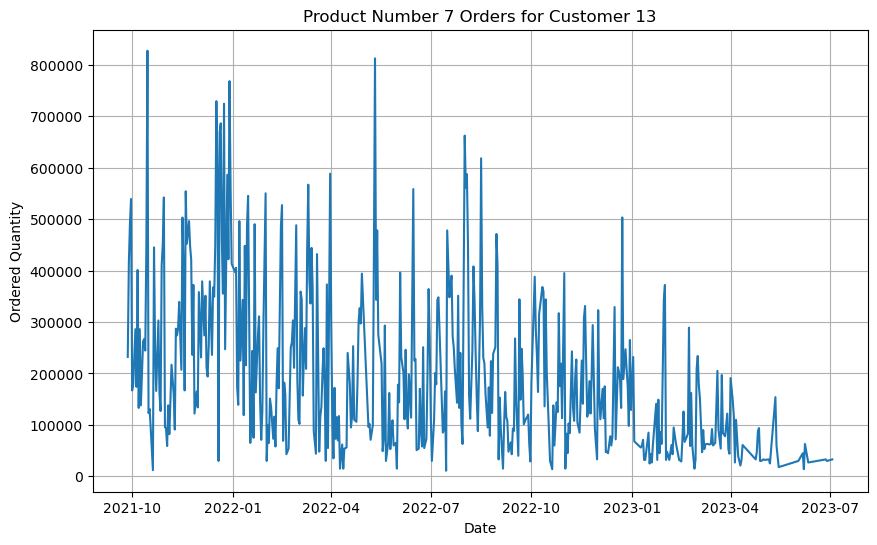

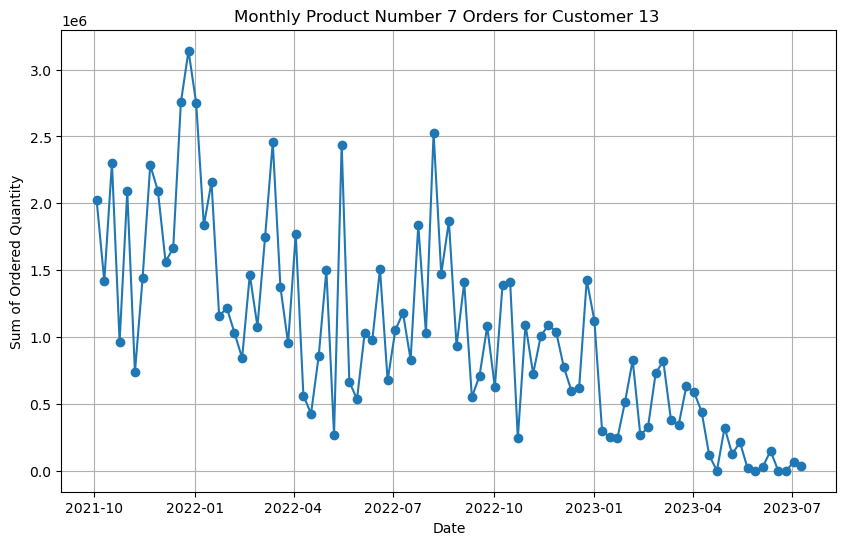

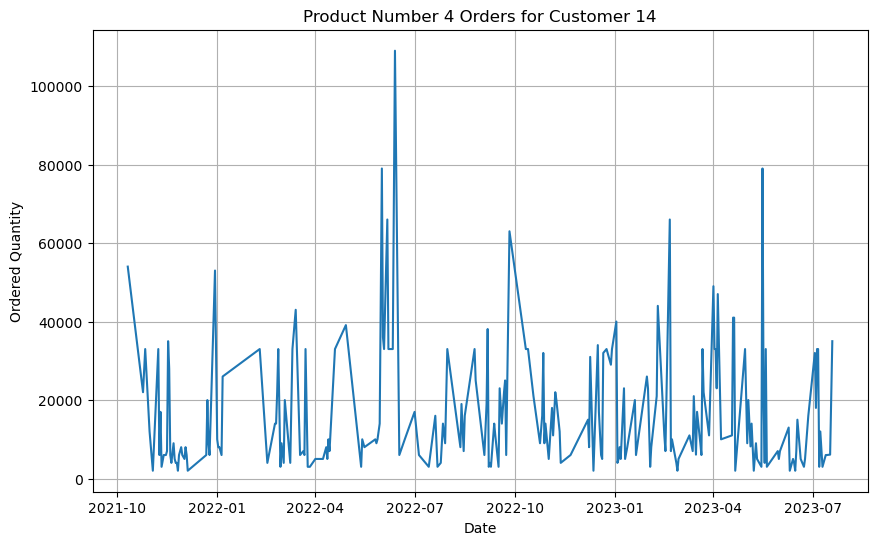

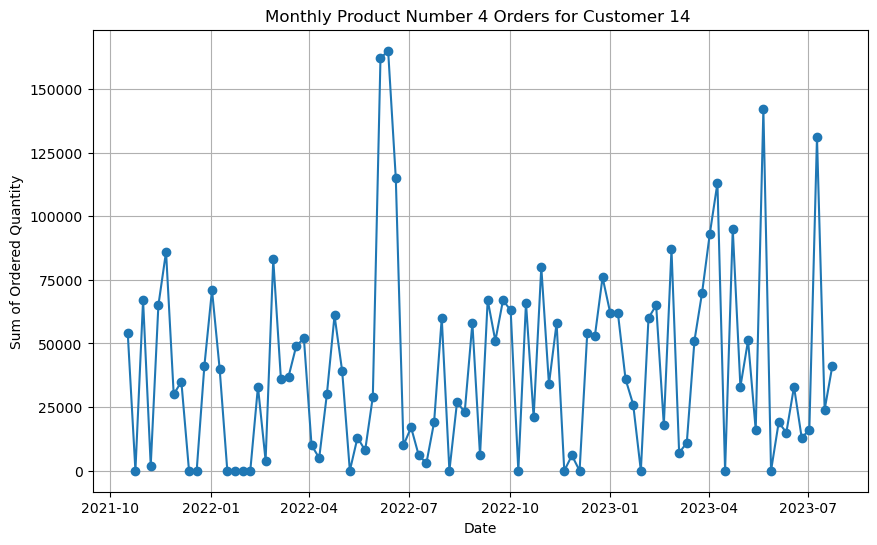

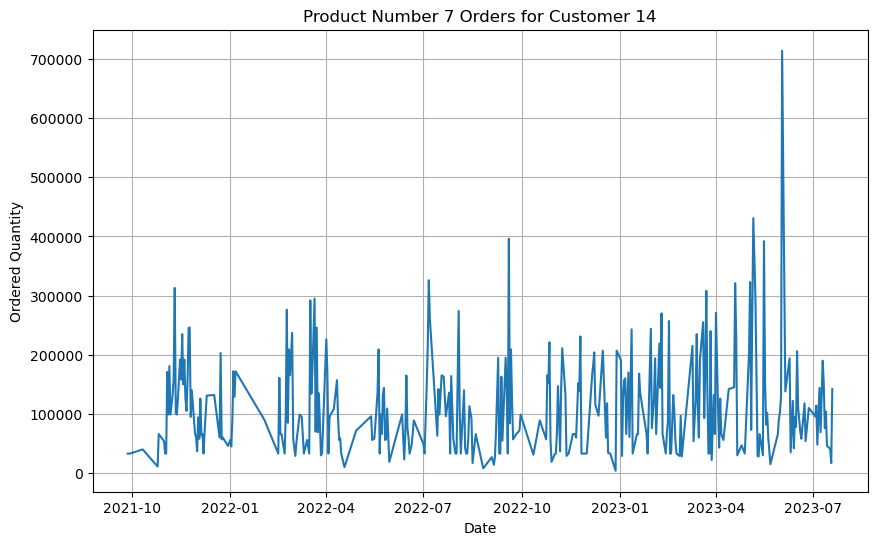

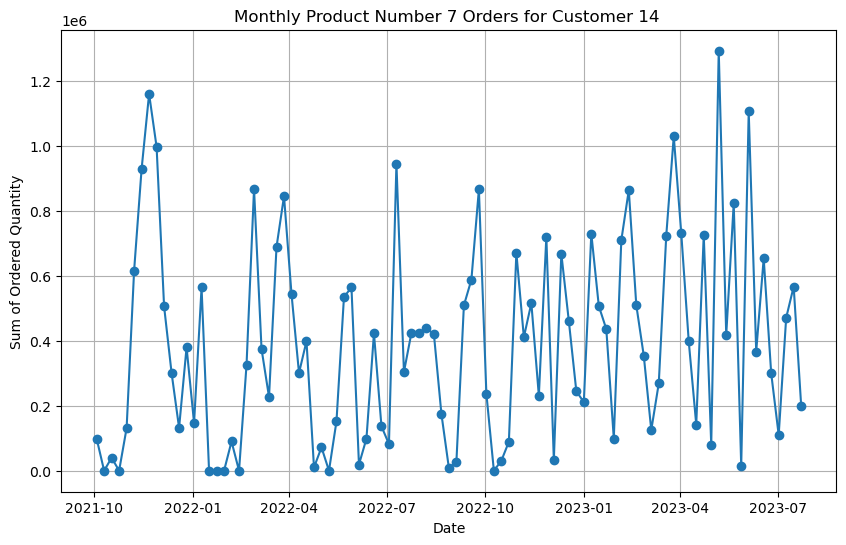

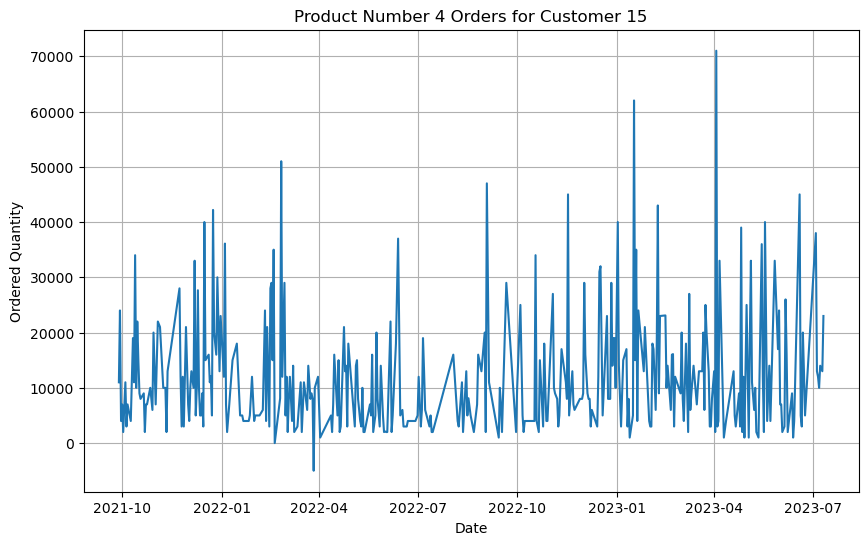

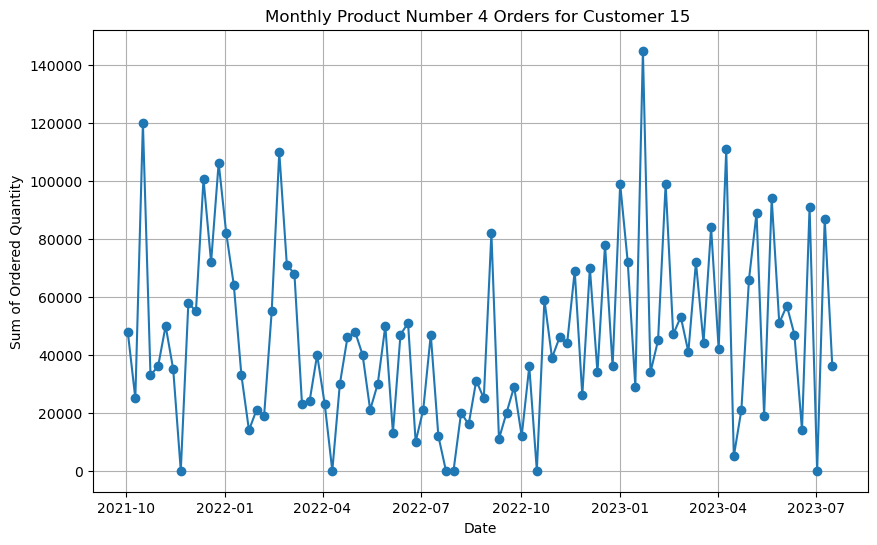

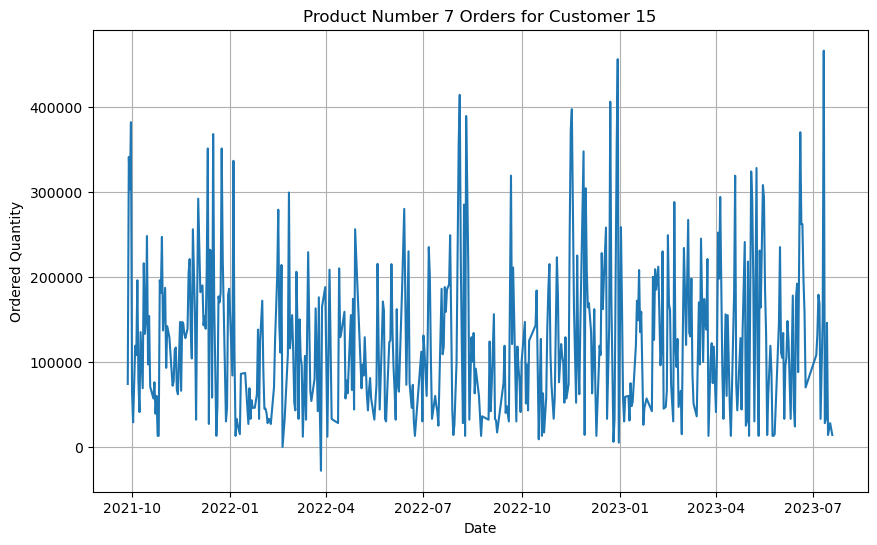

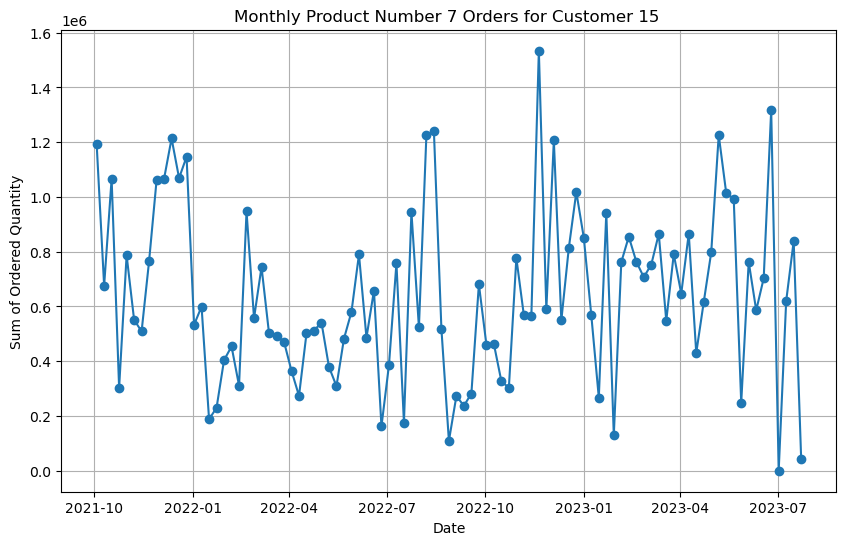

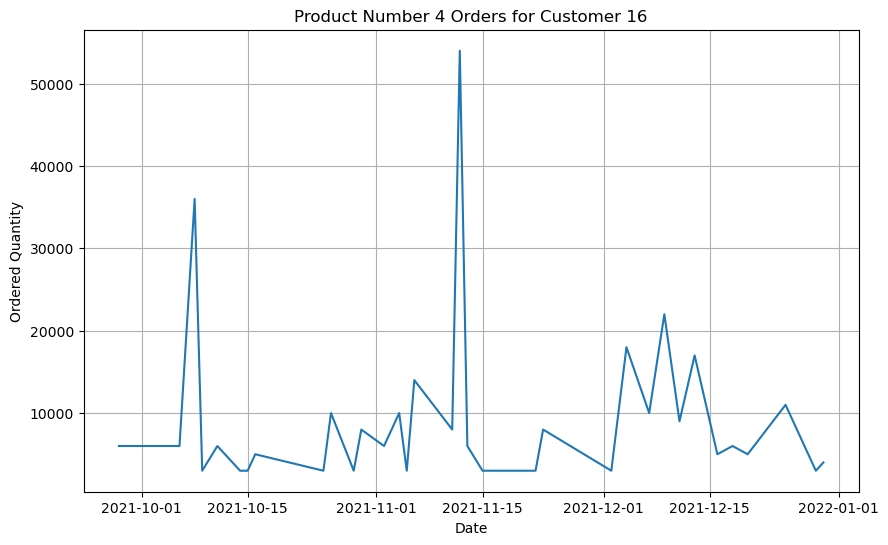

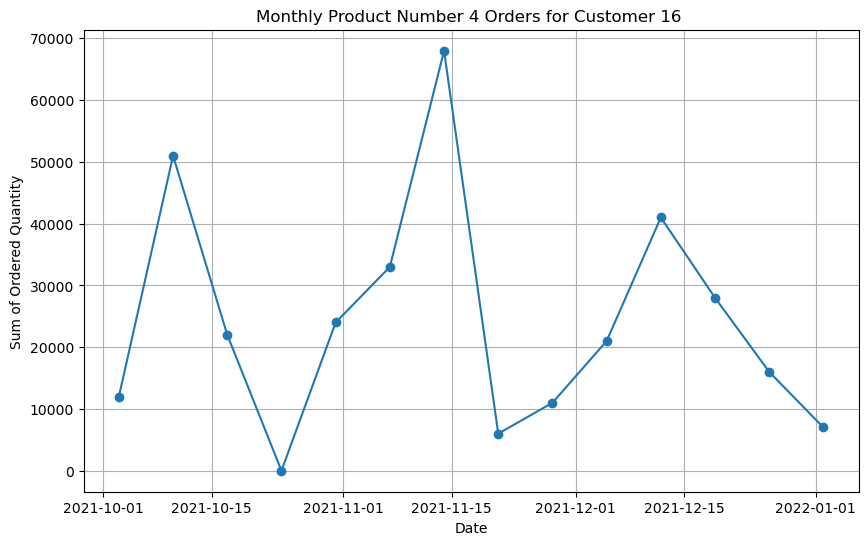

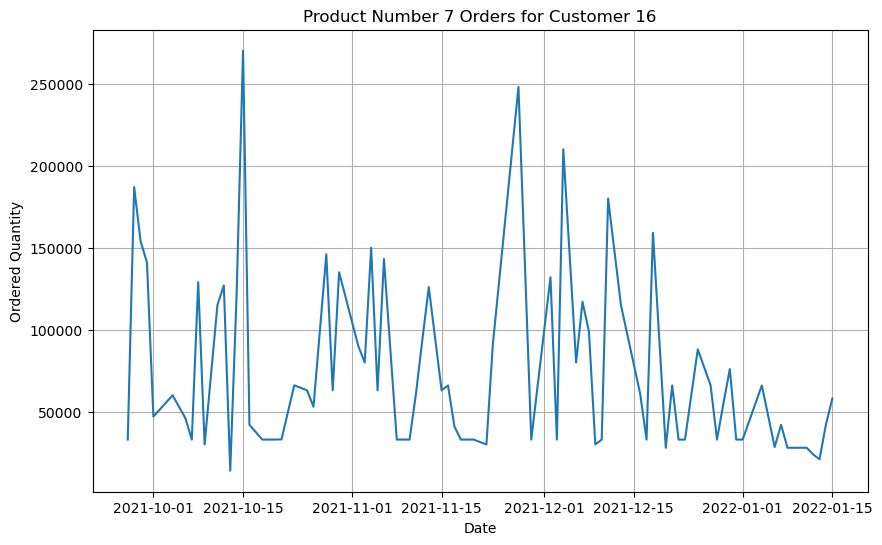

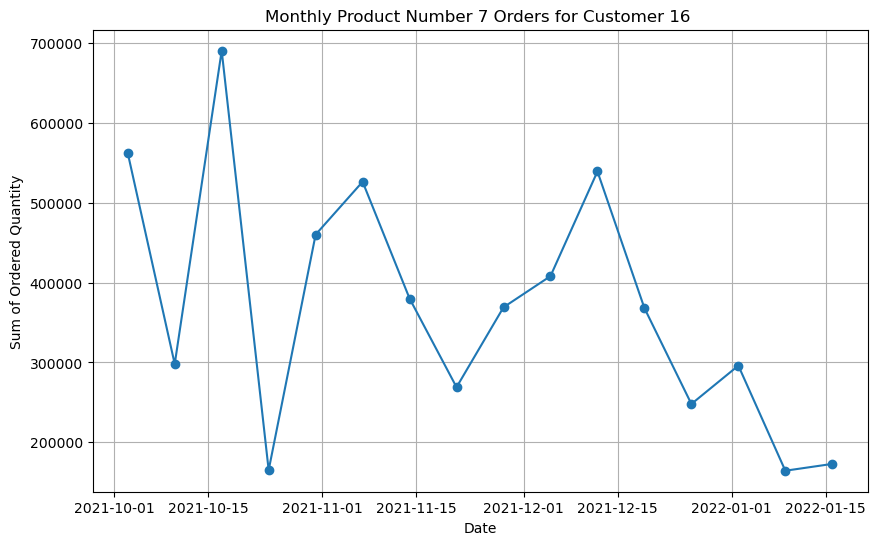

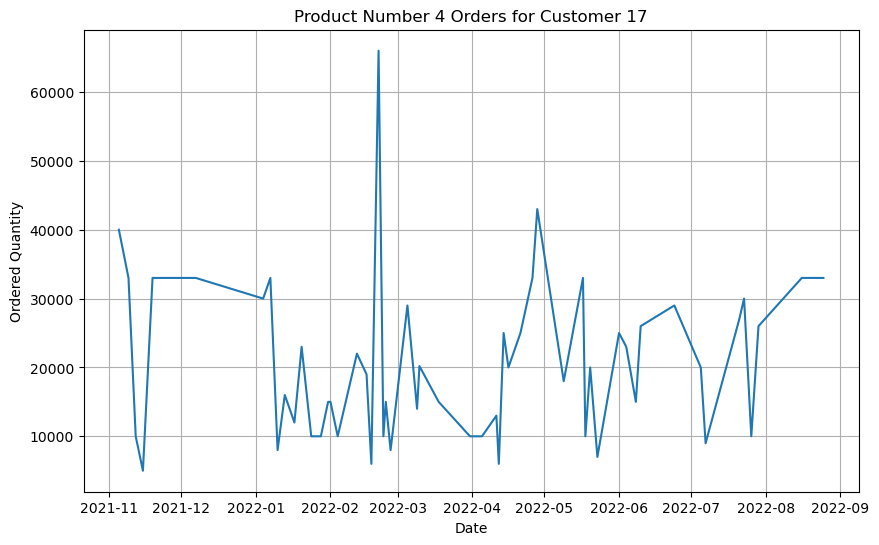

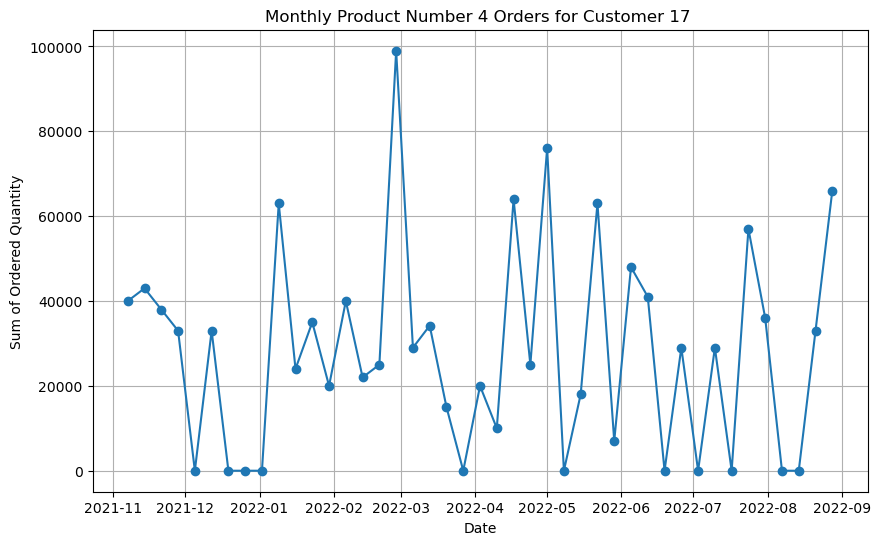

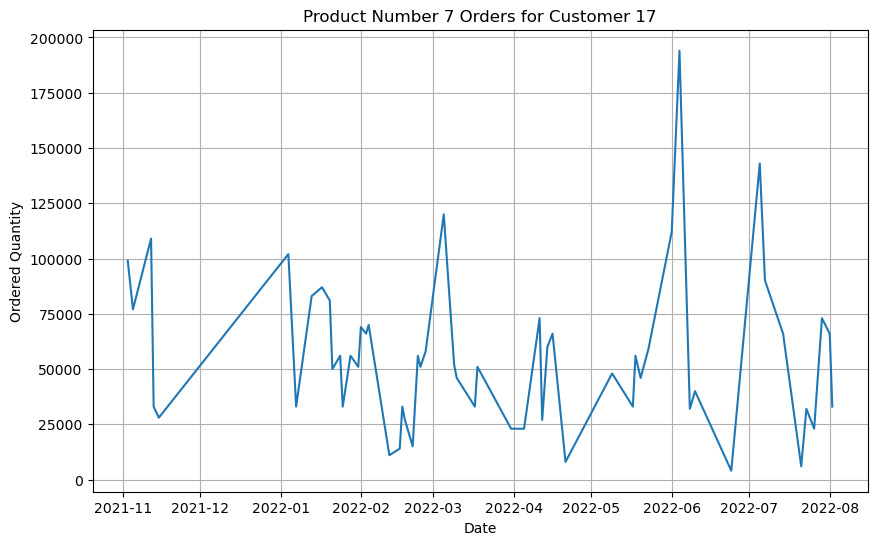

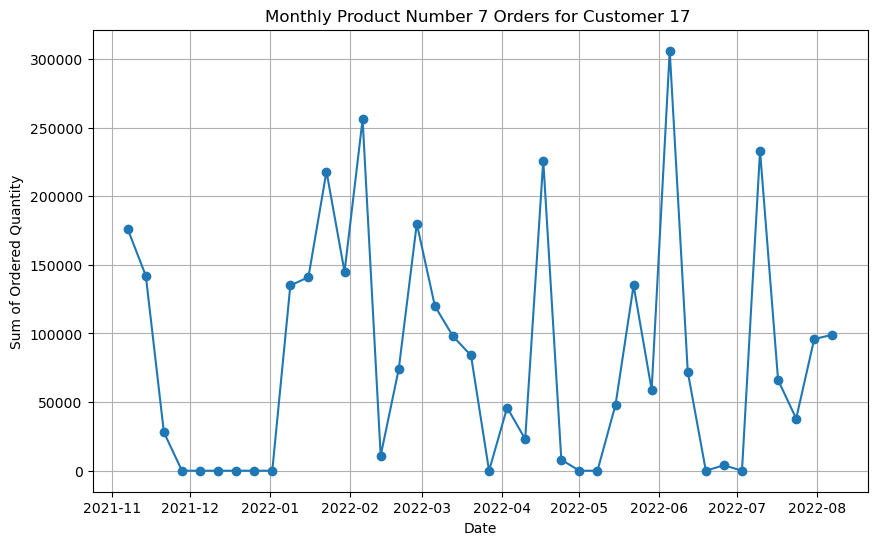

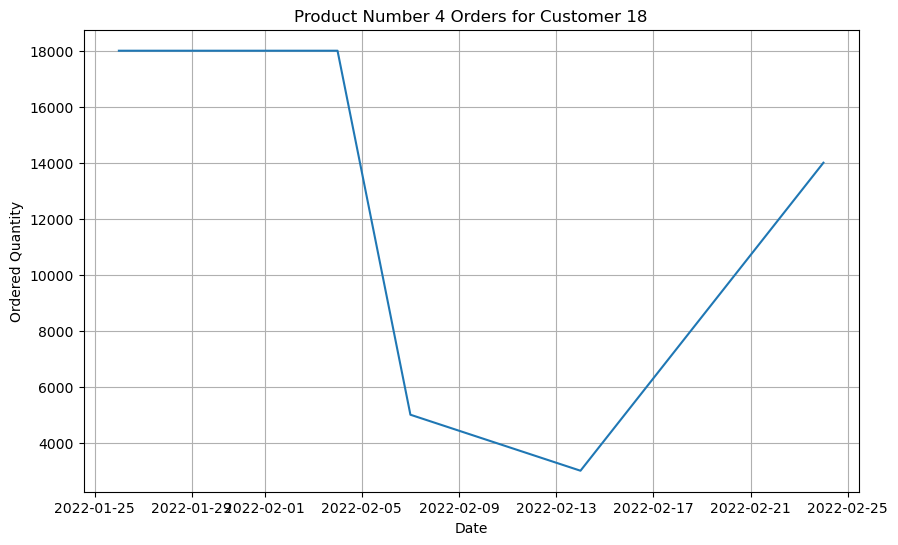

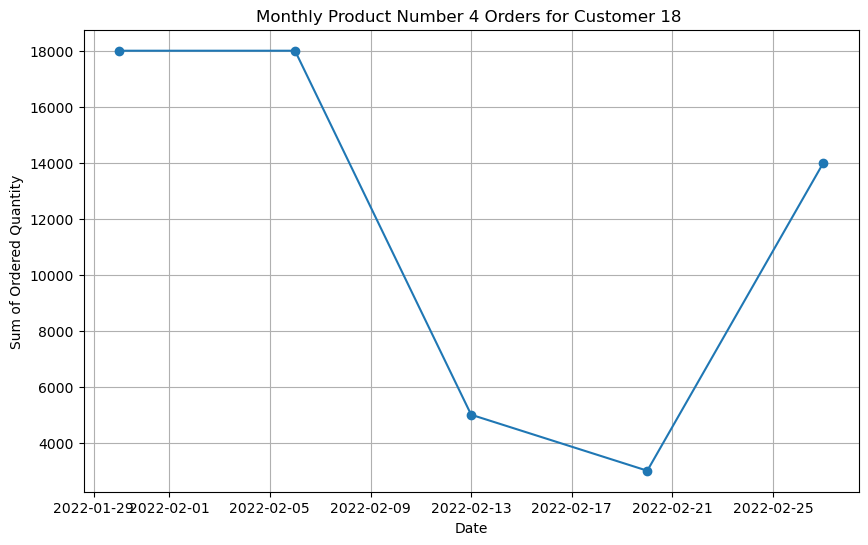

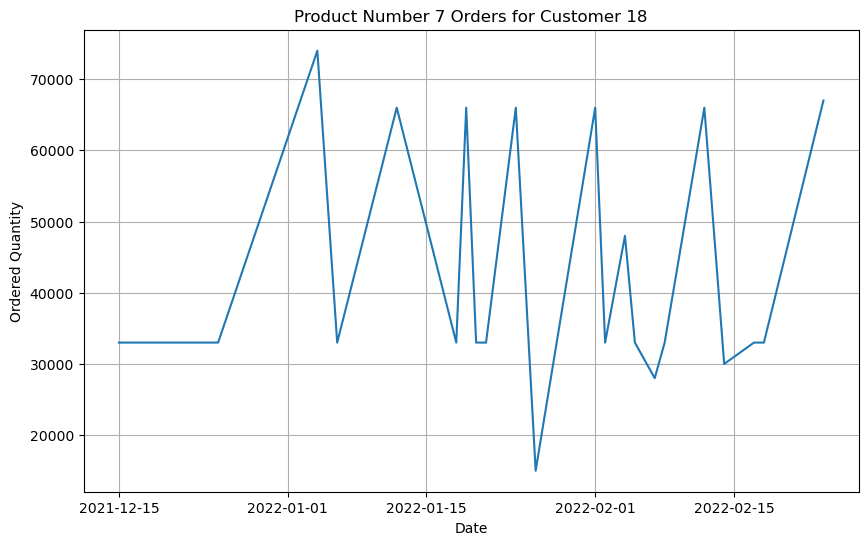

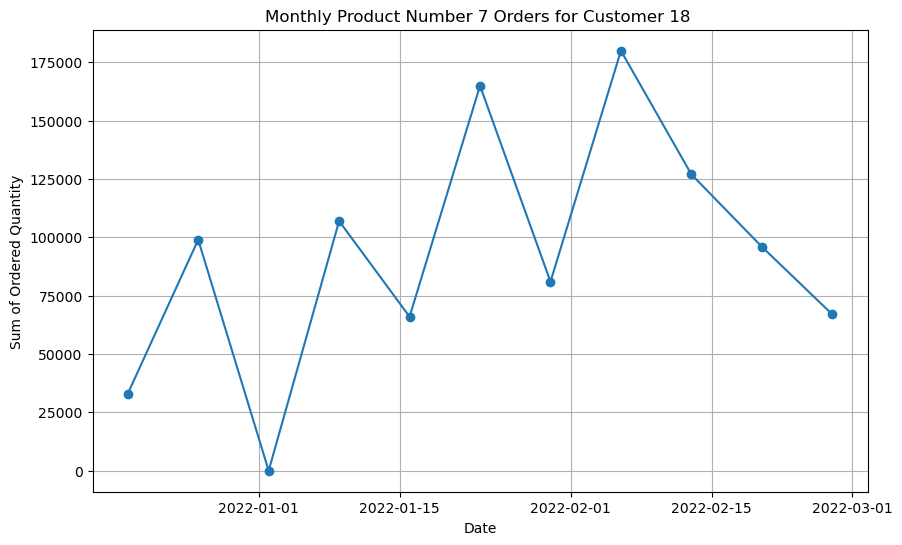

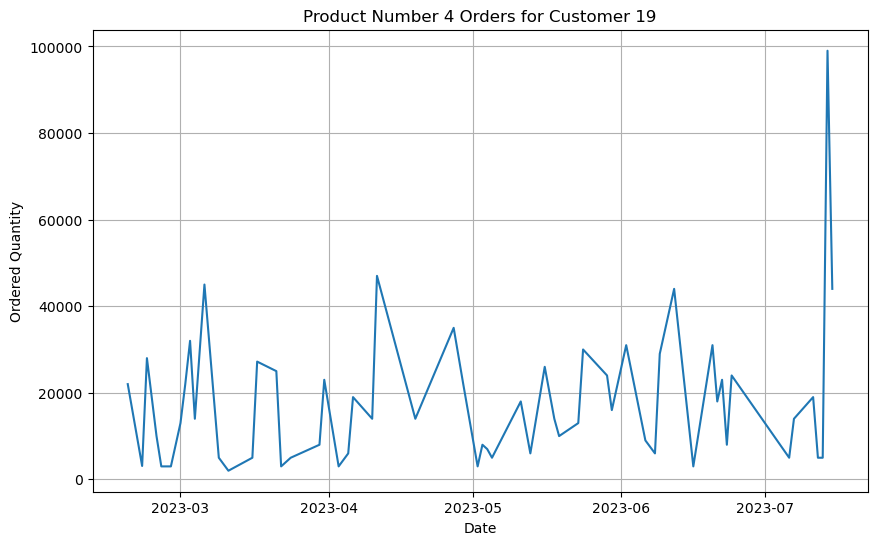

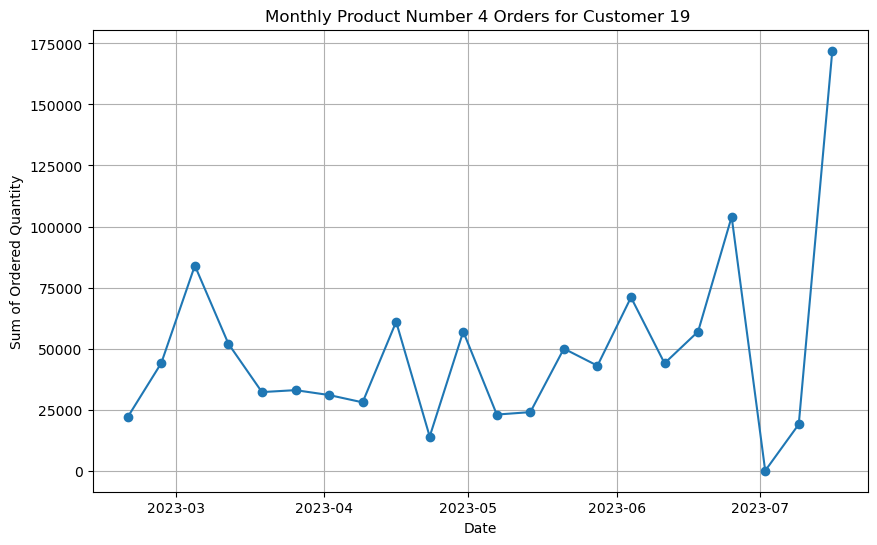

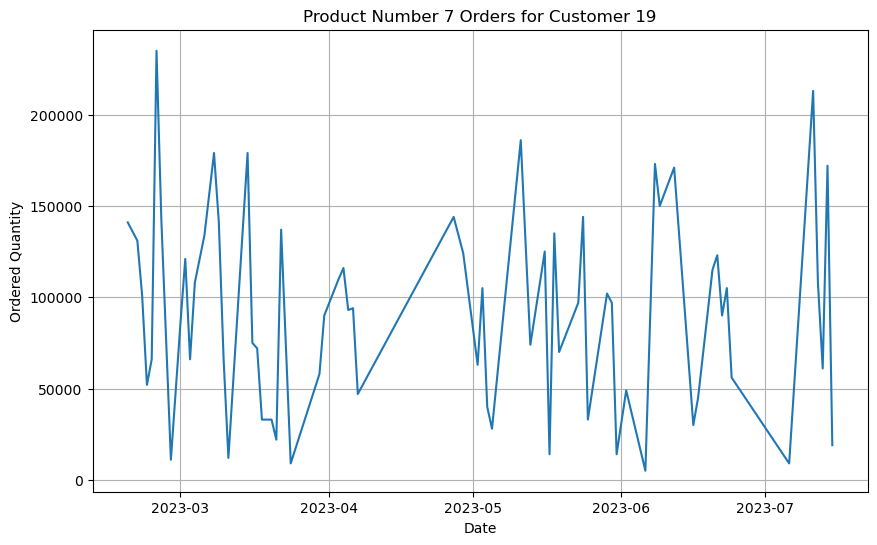

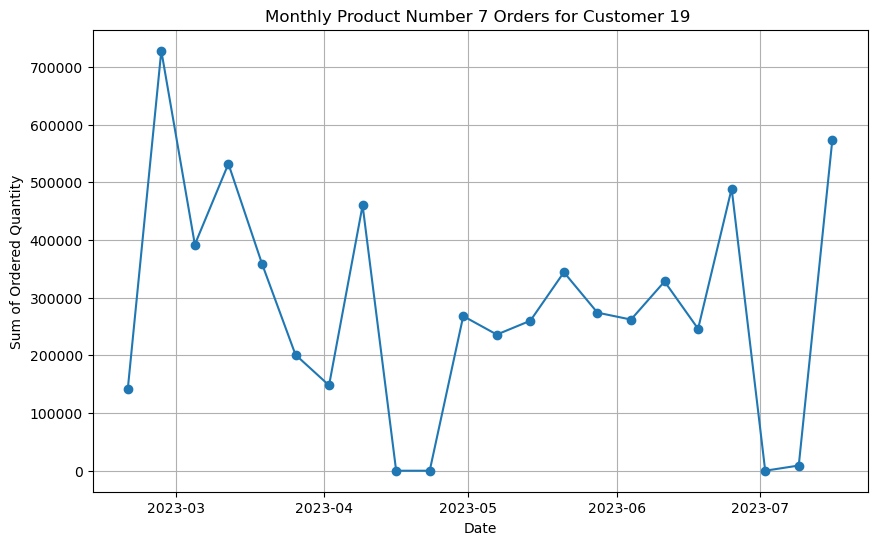

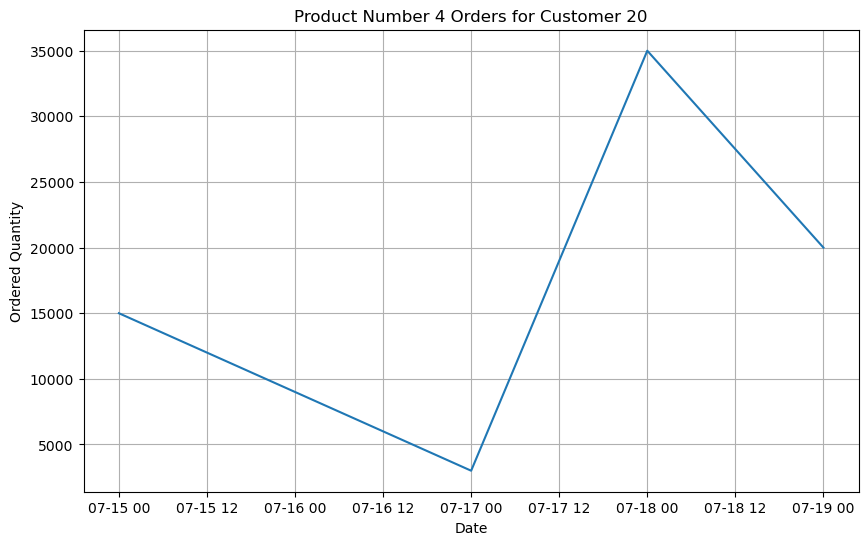

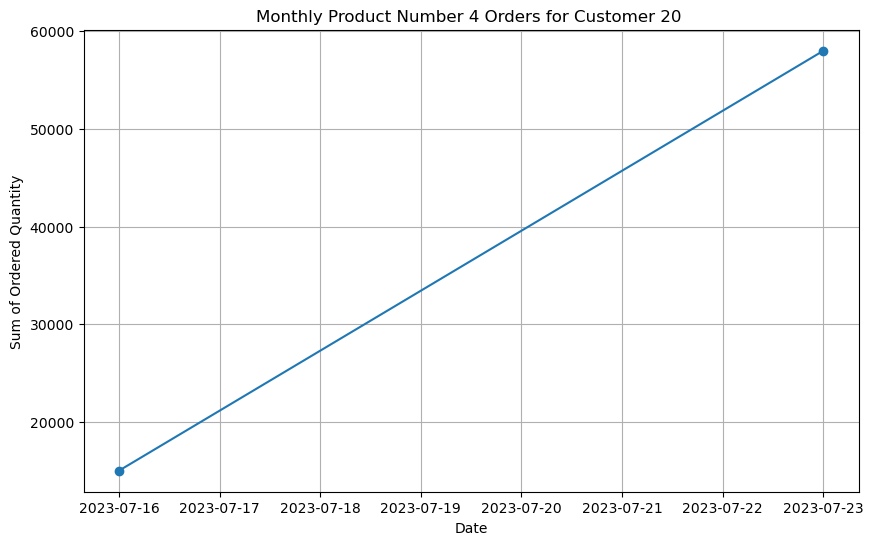

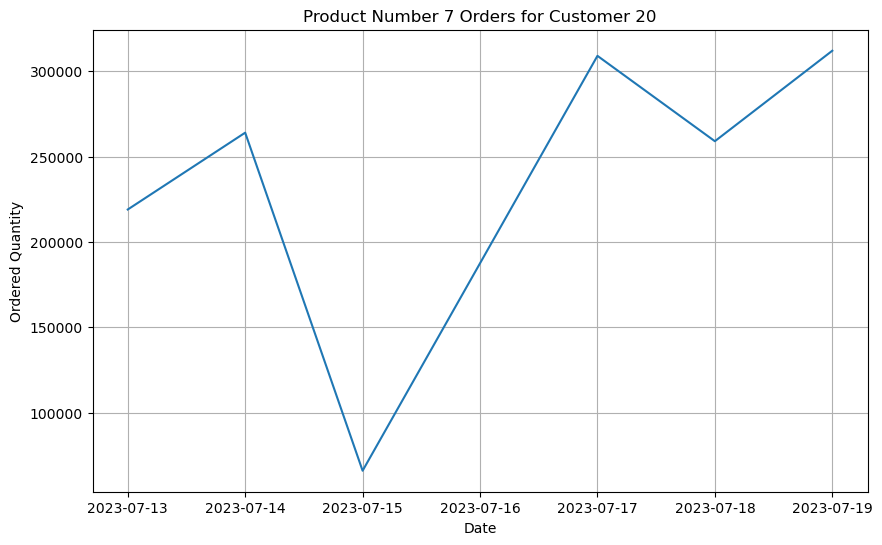

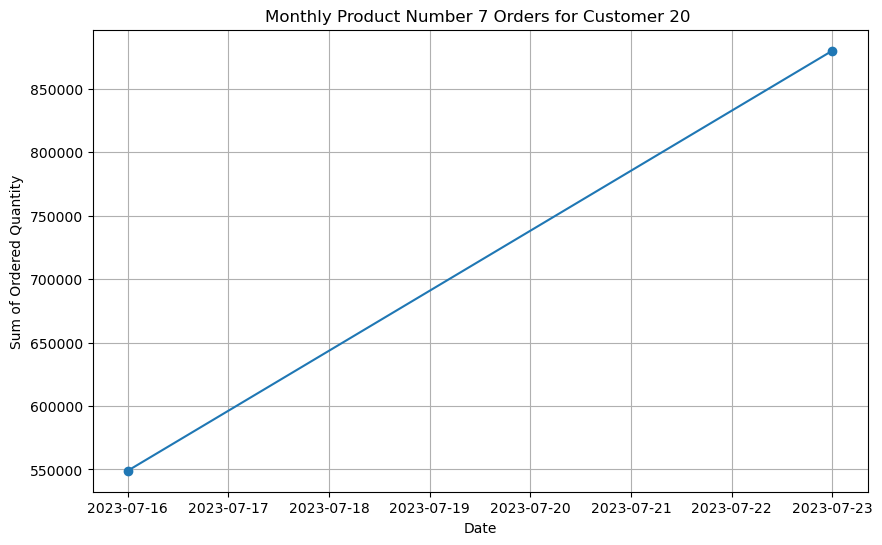

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Iterate over unique customer numbers
for customer_number in unique_customers:
    # Iterate over unique terminal product numbers for the current customer
    for product_number in unique_terminal_product_numbers:
        # Extract xts data for the current customer and product number
        xts_series = xts_data[f"xts_data_customer_{customer_number}_product_number_{product_number}"]
        
        # Plot the time series data
        plt.figure(figsize=(10, 6))
        plt.plot(xts_series)
        plt.title(f'Product Number {product_number} Orders for Customer {customer_number}')
        plt.xlabel('Date')
        plt.ylabel('Ordered Quantity')
        plt.grid(True)
        plt.show()
        
        # Resample the data to monthly frequency and plot
        product_data_monthly = xts_series.resample('W').sum()
        plt.figure(figsize=(10, 6))
        plt.plot(product_data_monthly, marker='o')
        plt.title(f'Monthly Product Number {product_number} Orders for Customer {customer_number} ')
        plt.xlabel('Date')
        plt.ylabel('Sum of Ordered Quantity')
        plt.grid(True)
        plt.show()

In [19]:
# example
print(data_customer_7_product_number_4)

      FOLIO_NUMBER  ORDERED_QUANTITY
5       2021-09-27              6000
53      2021-09-29             33000
79      2021-09-30             42000
103     2021-10-01             40000
149     2021-10-04             33000
...            ...               ...
13227   2023-07-12             18000
13252   2023-07-13             33000
13318   2023-07-16             18000
13330   2023-07-17             18000
13355   2023-07-18             33000

[405 rows x 2 columns]


In [20]:
# example
print(xts_data['xts_data_customer_3_product_number_4'])

FOLIO_NUMBER
2021-09-27     83100
2021-09-28    216100
2021-09-29    251400
2021-09-30    258200
2021-10-01    286300
               ...  
2023-07-15    219000
2023-07-16     59000
2023-07-17    276000
2023-07-18    422000
2023-07-19    262000
Length: 654, dtype: int64


# Customer 3 product number 4

In [21]:
product_data_monthly = xts_data['xts_data_customer_3_product_number_4'].resample('M').sum()

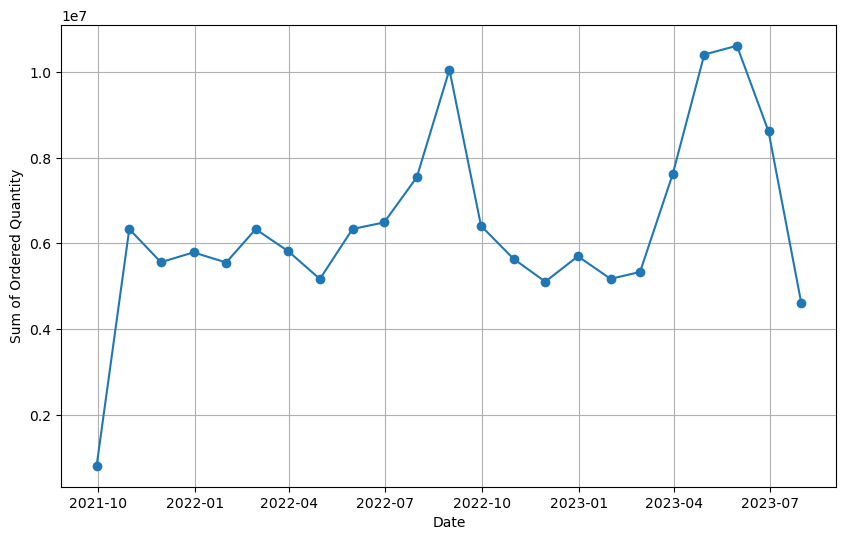

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(product_data_monthly, marker='o')
plt.xlabel('Date')
plt.ylabel('Sum of Ordered Quantity')
plt.grid(True)
plt.show()

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(time_series):
    adf_result = adfuller(time_series)
    adf_p_value = adf_result[1]
    if adf_p_value <= 0.05:
        adf_msg = "ADF test: The series is stationary."
    else:
        adf_msg = "ADF test: The series is non-stationary."
    return f"{adf_msg}\n"

In [24]:
# Check stationarity
result_message = check_stationarity(product_data_monthly)
print(result_message)

ADF test: The series is stationary.



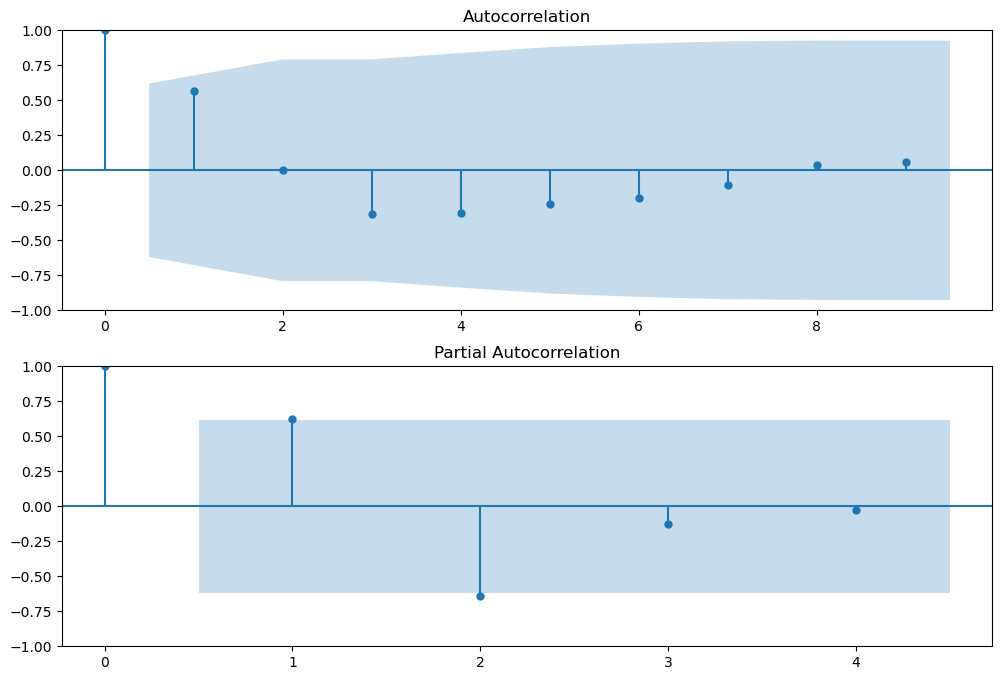

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(product_data_monthly.iloc[13:], lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(product_data_monthly.iloc[13:], lags=4, ax=ax2)
plt.show()

RMSE: 3757842.591697994


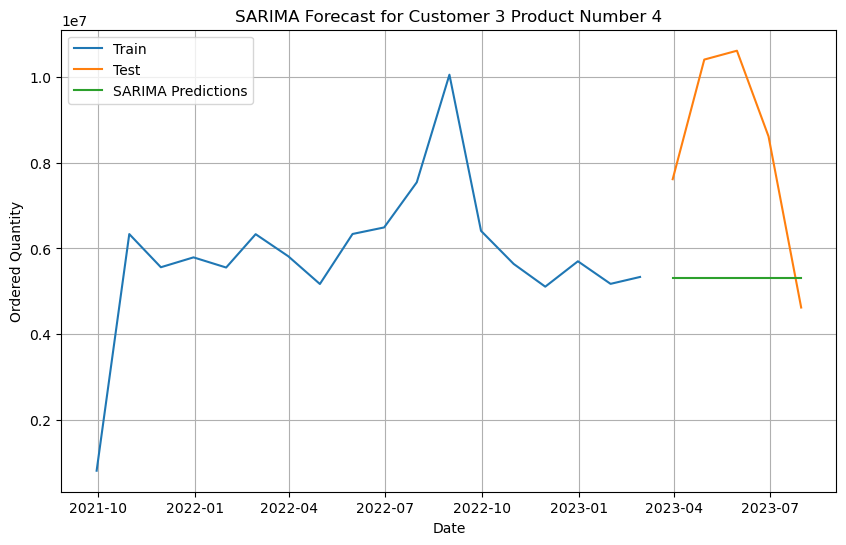

In [26]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(product_data_monthly) * 0.8)
train_data, test_data = product_data_monthly[:train_size], product_data_monthly[train_size:]
order =(0, 1, 1)  # (p, d, q)
seasonal_order = (1,0,2, 12)  # (P, D, Q, S)
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model = model.fit(disp=False)
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = sarima_model.predict(start=start, end=end, dynamic=False)
errors = test_data.values.squeeze() - predictions
mse = np.mean(errors ** 2)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Visualize actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, predictions, label='SARIMA Predictions')
plt.title('SARIMA Forecast for Customer 3 Product Number 4')
plt.xlabel('Date')
plt.ylabel('Ordered Quantity')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from pmdarima.arima import auto_arima

# Use auto_arima to find the best parameters
auto_model = auto_arima(train_data, seasonal=True, m=52, d=0, max_p=5, max_q=5, max_P=5, max_Q=5, trace=True, error_action='ignore', suppress_warnings=True)

# Get the best SARIMA parameters
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)

ValueError: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.